In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [2]:
data = pd.read_csv('gold_futures(in).csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Price Movement
0,1/2/2020,1518.099976,1528.699951,1518.000000,1524.500000,1524.500000,214,Up
1,1/3/2020,1530.099976,1552.699951,1530.099976,1549.199951,1549.199951,107,Up
2,1/6/2020,1580.000000,1580.000000,1560.400024,1566.199951,1566.199951,416,Up
3,1/7/2020,1558.300049,1576.300049,1558.300049,1571.800049,1571.800049,47,Up
4,1/8/2020,1579.699951,1604.199951,1552.300049,1557.400024,1557.400024,236,Down


# **Preprocessing**

In [3]:
# Convert Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Price Movement
0,2020-01-02,1518.099976,1528.699951,1518.000000,1524.500000,1524.500000,214,Up
1,2020-01-03,1530.099976,1552.699951,1530.099976,1549.199951,1549.199951,107,Up
2,2020-01-06,1580.000000,1580.000000,1560.400024,1566.199951,1566.199951,416,Up
3,2020-01-07,1558.300049,1576.300049,1558.300049,1571.800049,1571.800049,47,Up
4,2020-01-08,1579.699951,1604.199951,1552.300049,1557.400024,1557.400024,236,Down


In [4]:
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

data = data.drop(columns=['Date'])
data.head()


,Open,High,Low,Close,Adj Close,Volume,Price Movement,Year,Month,Day
0,1518.099976,1528.699951,1518.000000,1524.500000,1524.500000,214,Up,2020,1,2
1,1530.099976,1552.699951,1530.099976,1549.199951,1549.199951,107,Up,2020,1,3
2,1580.000000,1580.000000,1560.400024,1566.199951,1566.199951,416,Up,2020,1,6
3,1558.300049,1576.300049,1558.300049,1571.800049,1571.800049,47,Up,2020,1,7
4,1579.699951,1604.199951,1552.300049,1557.400024,1557.400024,236,Down,2020,1,8


In [5]:
data['Price Movement'] = data['Price Movement'].map({'Up': 1, 'Down': 0})

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
normalized_data

,Open,High,Low,Close,Adj Close,Volume,Price Movement,Year,Month,Day
0,0.037023,0.034253,0.049830,0.035998,0.035998,0.000852,1.0,0.0,0.0,0.033333
1,0.046127,0.052644,0.058979,0.054835,0.054835,0.000426,1.0,0.0,0.0,0.066667
2,0.083984,0.073563,0.081890,0.067800,0.067800,0.001656,1.0,0.0,0.0,0.166667
3,0.067521,0.070728,0.080303,0.072071,0.072071,0.000187,1.0,0.0,0.0,0.200000
4,0.083757,0.092107,0.075766,0.061089,0.061089,0.000939,0.0,0.0,0.0,0.233333
...,...,...,...,...,...,...,...,...,...,...
1240,0.905091,0.930421,0.914102,0.930674,0.930674,0.001739,1.0,1.0,1.0,0.300000
1241,0.935058,0.957701,0.938374,0.958283,0.958283,0.013479,1.0,1.0,1.0,0.333333
1242,0.952735,0.951035,0.926503,0.922971,0.922971,0.009412,0.0,1.0,1.0,0.366667
1243,0.924740,0.923602,0.904196,0.898948,0.898948,0.004477,0.0,1.0,1.0,0.400000


# **GAN-Defining**

In [7]:
import tensorflow as tf
import numpy as np

# Step 1: Define the Generator model
def build_generator(input_dim, output_dim):
    """
    input_dim: The size of the random noise vector (e.g., 100).
    output_dim: The size of the output data (number of features in the real data).
    """
    # Start building a simple model layer by layer
    model = tf.keras.Sequential([
        # First layer: 128 neurons with 'relu' activation to learn patterns
        # input_dim defines the size of the input noise vector.
        tf.keras.layers.Dense(128, activation='relu', input_dim=input_dim),

        # Second layer: 64 neurons to further refine the patterns
        tf.keras.layers.Dense(64, activation='relu'),

        # Final layer: Outputs a vector of size output_dim (same size as real data)
        # 'sigmoid' ensures the output values are between 0 and 1 (normalized).
        tf.keras.layers.Dense(output_dim, activation='sigmoid')
    ])

    # Return the generator model
    return model

In [8]:
# Step 2: Define the Discriminator model
def build_discriminator(input_dim):
    """
    input_dim: The size of the input data (number of features in the real or fake data).
    """
    # Start building the discriminator model layer by layer
    model = tf.keras.Sequential([
        # First layer: 128 neurons with 'relu' activation
        # The discriminator takes real or fake data as input (input_dim defines its size)
        tf.keras.layers.Dense(128, activation='relu', input_dim=input_dim),

        # Second layer: 64 neurons for further processing of the input
        tf.keras.layers.Dense(64, activation='relu'),

        # Final layer: Outputs a single value (0 or 1) indicating fake or real
        # 'sigmoid' is used because it outputs a probability between 0 and 1
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Return the discriminator model
    return model


In [9]:
# Step 3: Prepare the GAN model
def build_gan(generator, discriminator):
    """
    generator: The generator model that creates fake data.
    discriminator: The discriminator model that evaluates data (real or fake).
    """
    # Freeze the discriminator's weights during GAN training
    # This ensures the generator is the only model being updated when the GAN trains
    discriminator.trainable = False

    # Combine the generator and discriminator into one model
    # The generator outputs data, and the discriminator evaluates it
    model = tf.keras.Sequential([
        generator,       # The first step: Generate fake data
        discriminator    # The second step: Evaluate if the data looks real or fake
    ])

    # Return the combined GAN model
    return model


# **GAN-1**

**Experiment-1 (batch_size=32 - input_dim=100 - learning_rate=0.0002)**

In [ ]:
training_data = pd.DataFrame(normalized_data)

# Define the dimensions of the data
input_dim = 100  # Size of the random noise vector (input to the generator)
output_dim = training_data.shape[1]  # Number of features in the real dataset (output of the generator)
learning_rate = 0.0002

# Initialize the models
generator = build_generator(input_dim=input_dim, output_dim=output_dim)  # Generator creates fake data
discriminator = build_discriminator(input_dim=output_dim)  # Discriminator evaluates data
gan = build_gan(generator, discriminator)  # GAN combines the two models

# Compile the discriminator
discriminator.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),  # Adam optimizer for stable training
    loss='binary_crossentropy',                        # Binary crossentropy for classification (real or fake)
    metrics=['accuracy']                               # Track accuracy as an additional metric
)

# Compile the GAN
gan.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),  # Adam optimizer for generator updates
    loss='binary_crossentropy'                         # Binary crossentropy for GAN training
)

# Training parameters
epochs = 2000         # Total number of training iterations
batch_size = 32       # Number of samples per batch
half_batch = batch_size // 2  # Half of the batch size for discriminator training

# Ensure training data is in the correct format
normlized_data = training_data.astype(np.float32)  # Convert to 32-bit float (required by TensorFlow)

# Track loss trends
g_loss_history_1 = []
d_loss_history_1 = []

# Start training the GAN
for epoch in range(epochs):
    # Train the discriminator
    # Select a random batch of real data
    idx = np.random.randint(0, training_data.shape[0], half_batch)
    real_data = training_data.iloc[idx].values  # Use .iloc and convert to NumPy array

    # Generate fake data using the generator
    noise = np.random.normal(0, 1, (half_batch, input_dim)).astype(np.float32)  # Random noise as input
    fake_data = generator.predict(noise).astype(np.float32)  # Fake data output

    # Define labels for real (1) and fake (0) data
    real_labels = np.ones((half_batch, 1), dtype=np.float32)
    fake_labels = np.zeros((half_batch, 1), dtype=np.float32)

    # Train the discriminator on real data and fake data
    d_loss_real = discriminator.train_on_batch(real_data, real_labels)  # Train on real data
    d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)  # Train on fake data

    # Calculate the average loss of the discriminator
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator via the GAN
    noise = np.random.normal(0, 1, (batch_size, input_dim)).astype(np.float32)
    valid_labels = np.ones((batch_size, 1), dtype=np.float32)  # Labels for GAN training (all real)

    # Train the generator to "fool" the discriminator
    g_loss = gan.train_on_batch(noise, valid_labels)

    # Track loss
    g_loss_history_1.append(g_loss)
    d_loss_history_1.append(d_loss[0])

    # Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss[0]}, D Accuracy: {d_loss[1]} | G Loss: {g_loss}")






/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0 | D Loss: 0.6851522922515869, D Accuracy: 0.71875 | G Loss: [array(0.68418527, dtype=float32), array(0.68418527, dtype=float32), array(0.75, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

In [ ]:
# # Plot loss trends
# plt.figure(figsize=(10, 6))
# plt.plot(g_loss_history_1, label='Generator Loss')
# plt.plot(d_loss_history_1, label='Discriminator Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Loss Trends for Generator and Discriminator')
# plt.legend()
# plt.show()

# # Create a DataFrame for loss trends
# loss_trends_df = pd.DataFrame({
#     'Epoch': list(range(1, len(g_loss_history_1) + 1)),
#     'Generator Loss': g_loss_history_1,
#     'Discriminator Loss': d_loss_history_1
# })

# # Filter the DataFrame to include only every 100th epoch
# loss_trends_df_filtered_1 = loss_trends_df[loss_trends_df['Epoch'] % 100 == 0]

# # Compute average losses for every 100 epochs
# loss_trends_df['Epoch Group'] = ((loss_trends_df['Epoch'] - 1) // 100) + 1
# average_losses_df_1 = loss_trends_df.groupby('Epoch Group').agg({
#     'Generator Loss': 'mean',
#     'Discriminator Loss': 'mean'
# }).reset_index()
# average_losses_df_1['Epoch Range'] = average_losses_df_1['Epoch Group'].apply(
#     lambda x: f"{(x - 1) * 100 + 1}-{x * 100}"
# )
# average_losses_df_1 = average_losses_df_1[['Epoch Range', 'Generator Loss', 'Discriminator Loss']]

# # Print the filtered and average loss trends
# print("\nLoss Trends Comparison Table (Every 100 Epochs):")
# print(loss_trends_df_filtered_1)
# print("\nAverage Loss Trends for Every 100 Epochs:")
# print(average_losses_df_1)



In [ ]:
# Create a DataFrame for loss trends
loss_trends_df_1 = pd.DataFrame({
    'Epoch': list(range(1, len(g_loss_history_1) + 1)),
    'Generator Loss': g_loss_history_1,
    'Discriminator Loss': d_loss_history_1
})

# Compute the average Generator Loss for each epoch
loss_trends_df_1['Generator Loss (Avg)'] = loss_trends_df_1['Generator Loss'].apply(lambda x: sum(x) / len(x) if isinstance(x, list) else x)

# Filter the DataFrame to include only every 100th epoch
loss_trends_df_filtered_1 = loss_trends_df_1[loss_trends_df_1['Epoch'] % 100 == 0]

# Display the filtered loss trends DataFrame
print("\nLoss Trends Comparison Table (Every 100 Epochs):")
print(loss_trends_df_filtered_1[['Epoch', 'Generator Loss (Avg)', 'Discriminator Loss']])



Loss Trends Comparison Table (Every 100 Epochs):
      Epoch  Generator Loss (Avg)  Discriminator Loss
99      100              0.587764            0.712392
199     200              0.595936            0.735310
299     300              0.603611            0.749998
399     400              0.607805            0.758503
499     500              0.610826            0.764146
599     600              0.612610            0.767954
699     700              0.614218            0.770661
799     800              0.615255            0.772709
899     900              0.616103            0.774314
999    1000              0.616985            0.775606
1099   1100              0.617558            0.776695
1199   1200              0.618317            0.777569
1299   1300              0.619073            0.778300
1399   1400              0.619429            0.778956
1499   1500              0.619769            0.779541
1599   1600              0.620084            0.780031
1699   1700              0.62019

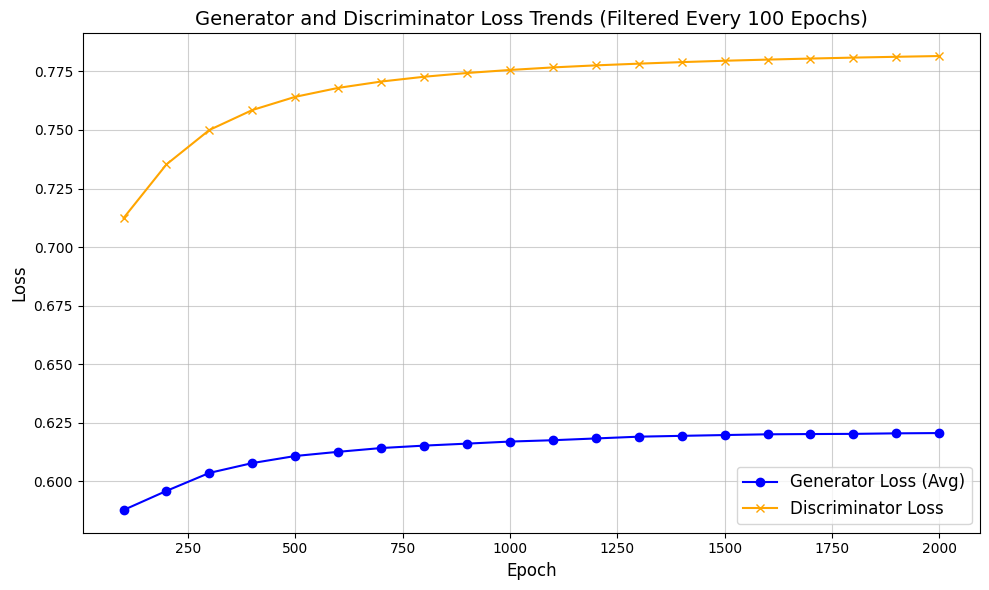

In [ ]:
import matplotlib.pyplot as plt

# Filter the DataFrame to include only every 100th epoch
loss_trends_df_filtered_1 = loss_trends_df_1[loss_trends_df_1['Epoch'] % 100 == 0]

# Plot the average Generator Loss and Discriminator Loss
plt.figure(figsize=(10, 6))

# Plot Generator Loss (Avg)
plt.plot(loss_trends_df_filtered_1['Epoch'], loss_trends_df_filtered_1['Generator Loss (Avg)'],
         label='Generator Loss (Avg)', color='blue', marker='o')

# Plot Discriminator Loss
plt.plot(loss_trends_df_filtered_1['Epoch'], loss_trends_df_filtered_1['Discriminator Loss'],
         label='Discriminator Loss', color='orange', marker='x')

# Add titles and labels
plt.title('Generator and Discriminator Loss Trends (Filtered Every 100 Epochs)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Generate 10,000 synthetic samples
noise = np.random.normal(0, 1, (10000, input_dim)).astype(np.float32)
synthetic_data_1 = generator.predict(noise)

synthetic_data_reshaped_1 = synthetic_data_1.reshape(-1, output_dim)
original_scale_data_1 = scaler.inverse_transform(synthetic_data_reshaped_1)  # Rescale synthetic data
synthetic_data_df_1 = pd.DataFrame(original_scale_data_1, columns=data.columns)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


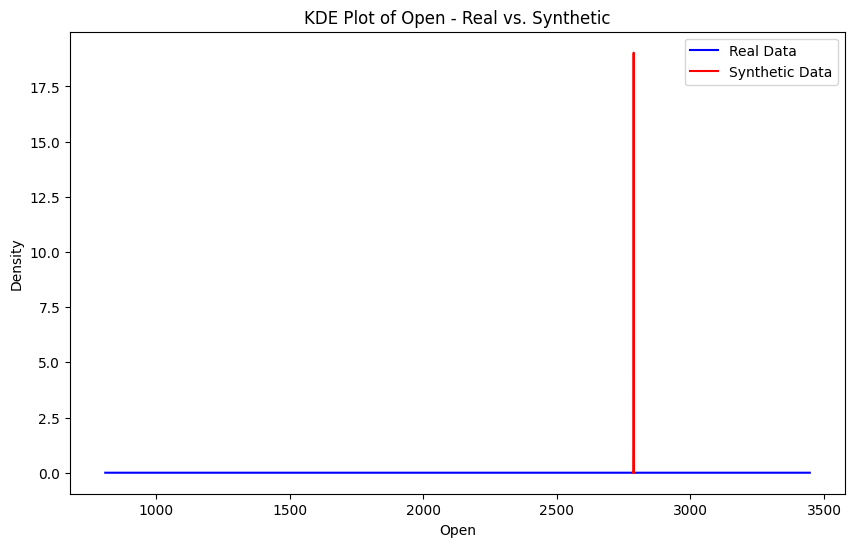

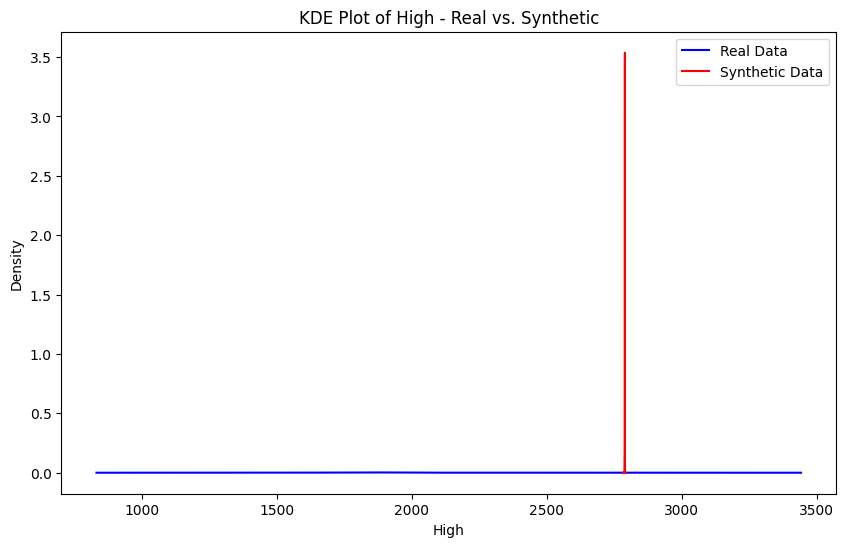

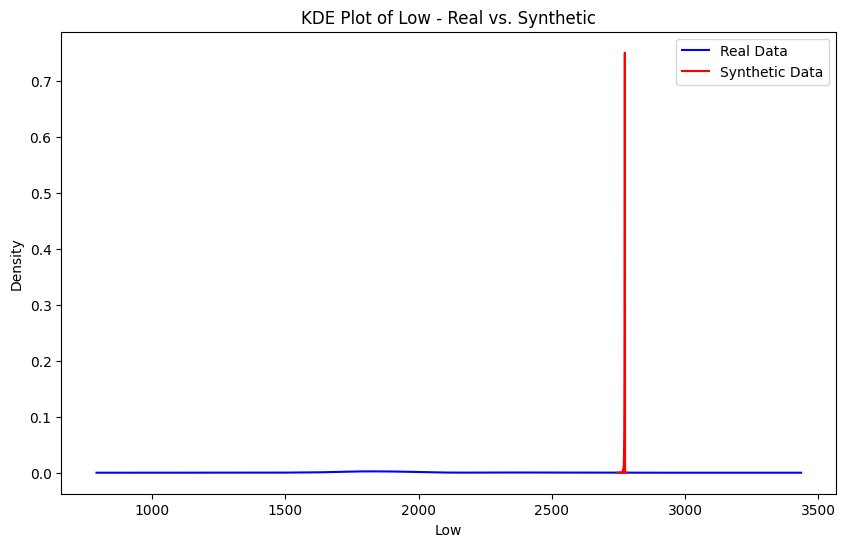

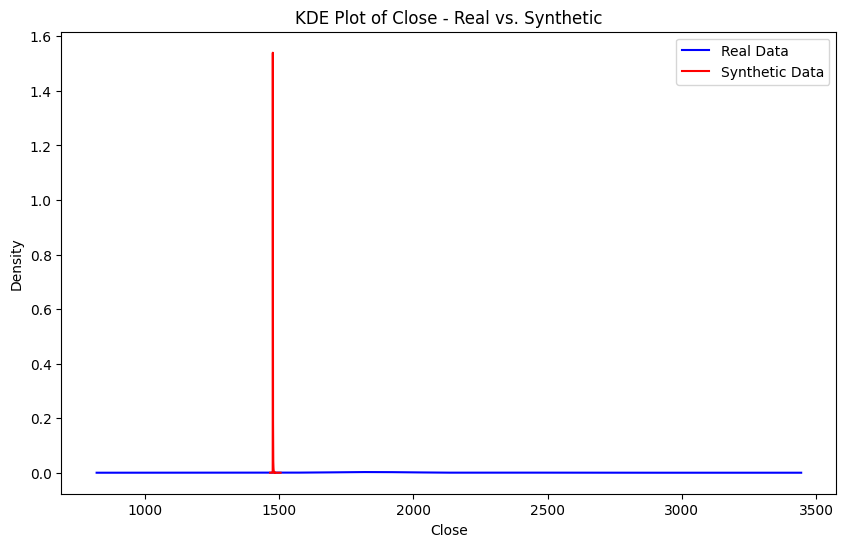

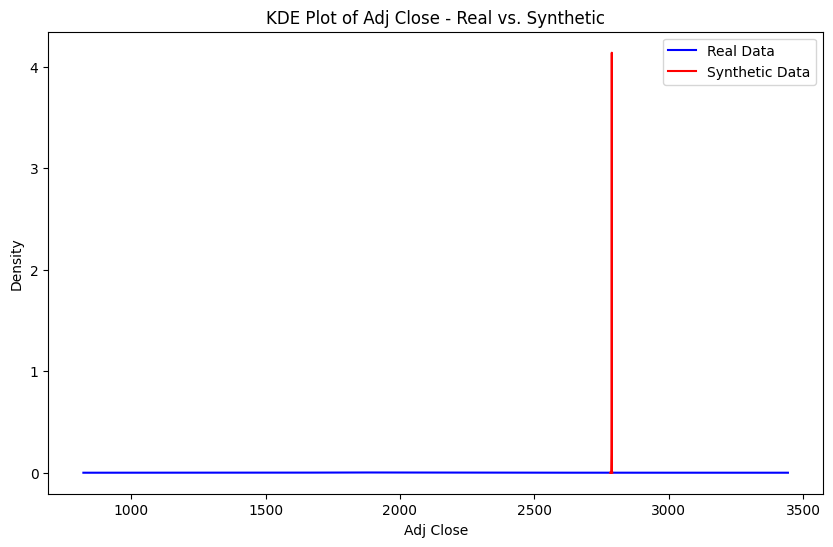

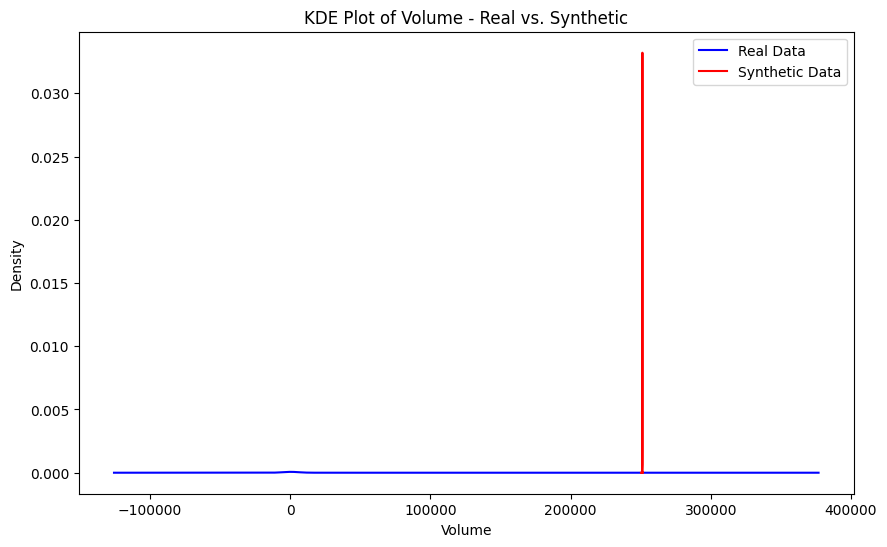

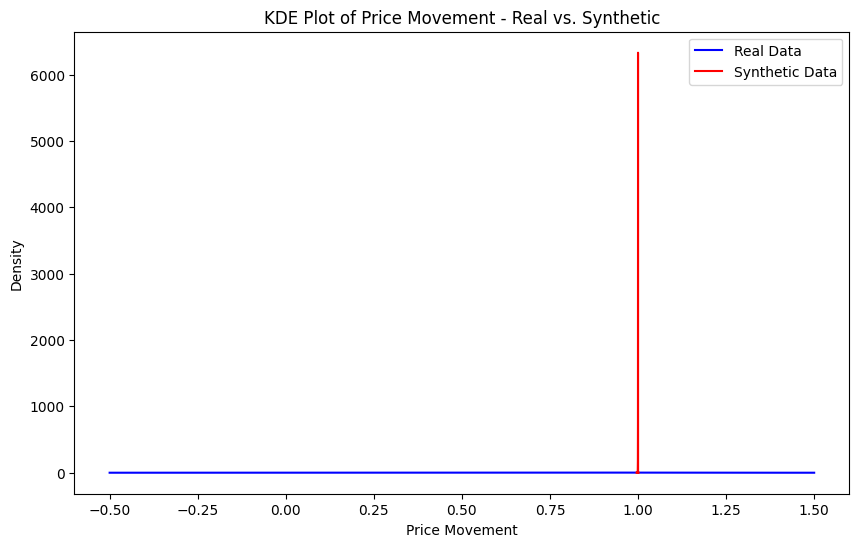

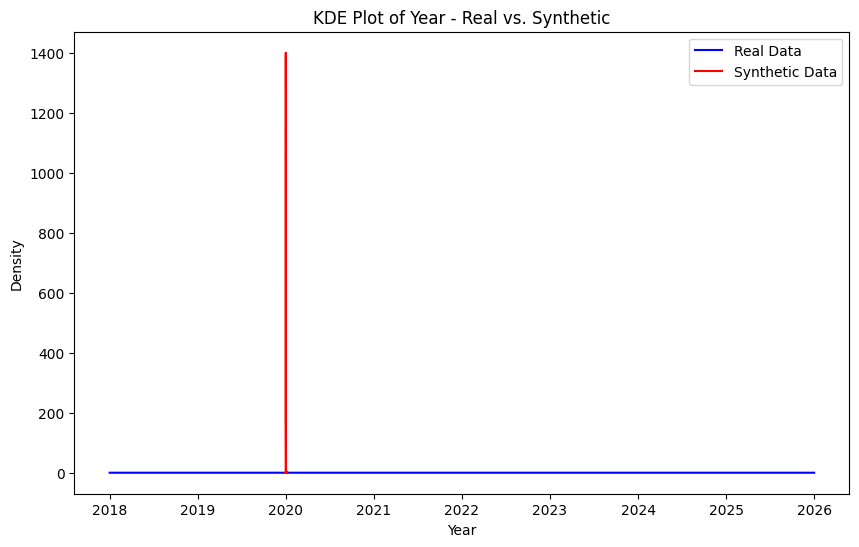

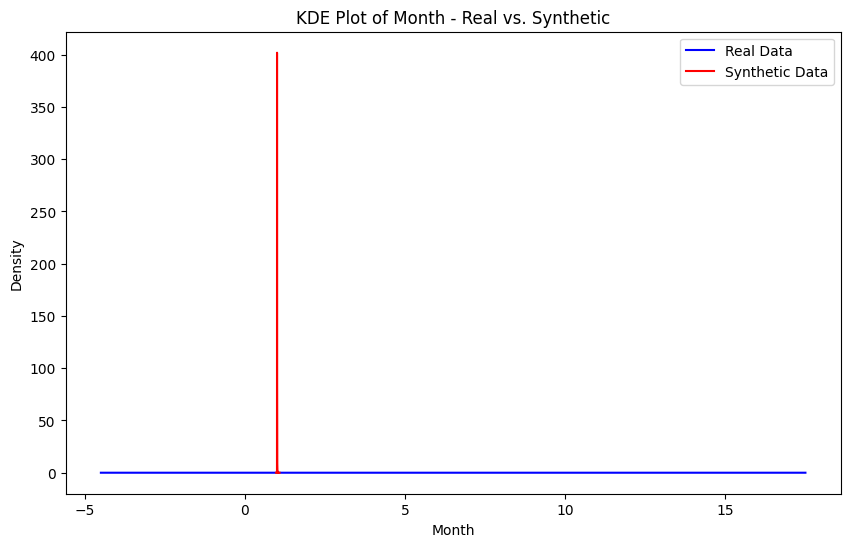

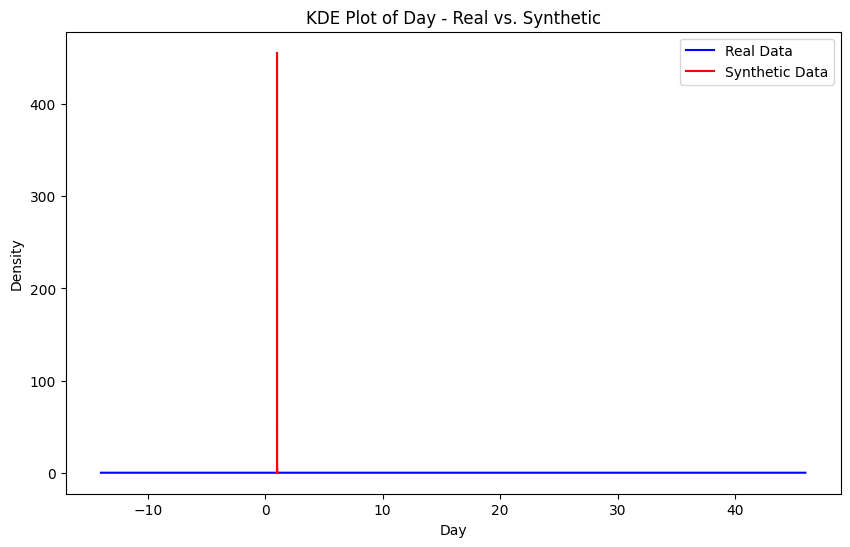

In [ ]:
 #Compare distributions using Kernel Density Estimation (KDE) plots
for col in data.columns:
    plt.figure(figsize=(10, 6))
    data[col].plot.kde(label='Real Data', color='blue')
    pd.Series(synthetic_data_df_1[col]).plot.kde(label='Synthetic Data', color='red')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.title(f'KDE Plot of {col} - Real vs. Synthetic')
    plt.legend(loc='upper right')
    plt.show()


In [ ]:
# Statistical comparison
real_stats = data.describe()
synthetic_stats = synthetic_data_df_1.describe()

print("\nReal Data Statistics_1:")
real_stats




Real Data Statistics_1:


,Open,High,Low,Close,Adj Close,Volume,Price Movement,Year,Month,Day
count,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000
mean,1935.453574,1945.315985,1925.952770,1935.689395,1935.689395,4225.694779,0.548594,2021.983133,6.503614,15.635341
std,260.426016,261.177932,259.766152,260.533468,260.533468,23181.283059,0.497833,1.410983,3.409278,8.765911
min,1469.300049,1484.000000,1452.099976,1477.300049,1477.300049,0.000000,0.000000,2020.000000,1.000000,1.000000
25%,1779.500000,1787.800049,1770.099976,1777.199951,1777.199951,74.000000,0.000000,2021.000000,4.000000,8.000000
50%,1869.300049,1876.000000,1862.599976,1868.300049,1868.300049,231.000000,1.000000,2022.000000,7.000000,15.000000
75%,1988.199951,1994.599976,1977.699951,1985.000000,1985.000000,645.000000,1.000000,2023.000000,9.000000,23.000000
max,2787.399902,2789.000000,2774.600098,2788.500000,2788.500000,251274.000000,1.000000,2024.000000,12.000000,31.000000


In [ ]:
print("\nSynthetic Data Statistics_1:")
synthetic_stats


Synthetic Data Statistics_1:


,Open,High,Low,Close,Adj Close,Volume,Price Movement,Year,Month,Day
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2787.358887,2788.779297,2773.541260,1477.811768,2788.305908,251250.296875,0.999874,2020.000366,1.001994,1.001742
std,0.175362,0.397325,1.149283,0.707666,0.324013,33.295532,0.000176,0.000777,0.002570,0.002509
min,2786.474854,2784.513916,2756.312744,1477.301636,2784.760010,250615.734375,0.997241,2020.000000,1.000003,1.000005
25%,2787.354004,2788.731934,2773.256714,1477.430634,2788.260193,251245.828125,0.999849,2020.000122,1.000527,1.000390
50%,2787.380615,2788.869629,2773.894775,1477.587646,2788.387207,251260.843750,0.999930,2020.000366,1.001154,1.000920
75%,2787.392090,2788.942627,2774.243896,1477.926270,2788.448486,251268.285156,0.999969,2020.000732,1.002450,1.002051
max,2787.399902,2788.998779,2774.593262,1496.715088,2788.499023,251273.921875,1.000000,2020.009888,1.052673,1.041880


# **GAN-2**

**Experiment-2 (batch_size=64 - input_dim=50 - learning_rate=0,0001)**

In [ ]:
training_data = pd.DataFrame(normalized_data)

# Define the dimensions of the data
input_dim = 50  # Size of the random noise vector (input to the generator)
output_dim = training_data.shape[1]  # Number of features in the real dataset (output of the generator)
learning_rate = 0.0001

# Initialize the models
generator = build_generator(input_dim=input_dim, output_dim=output_dim)  # Generator creates fake data
discriminator = build_discriminator(input_dim=output_dim)  # Discriminator evaluates data
gan = build_gan(generator, discriminator)  # GAN combines the two models

# Compile the discriminator
discriminator.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),  # Adam optimizer for stable training
    loss='binary_crossentropy',                        # Binary crossentropy for classification (real or fake)
    metrics=['accuracy']                               # Track accuracy as an additional metric
)

# Compile the GAN
gan.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),  # Adam optimizer for generator updates
    loss='binary_crossentropy'                         # Binary crossentropy for GAN training
)

# Training parameters
epochs = 2000         # Total number of training iterations
batch_size = 64       # Number of samples per batch
half_batch = batch_size // 2  # Half of the batch size for discriminator training

# Ensure training data is in the correct format
normlized_data = training_data.astype(np.float32)  # Convert to 32-bit float (required by TensorFlow)

# Track loss trends
g_loss_history_2 = []
d_loss_history_2 = []

# Start training the GAN
for epoch in range(epochs):
    # Train the discriminator
    # Select a random batch of real data
    idx = np.random.randint(0, training_data.shape[0], half_batch)
    real_data = training_data.iloc[idx].values  # Use .iloc and convert to NumPy array

    # Generate fake data using the generator
    noise = np.random.normal(0, 1, (half_batch, input_dim)).astype(np.float32)  # Random noise as input
    fake_data = generator.predict(noise).astype(np.float32)  # Fake data output

    # Define labels for real (1) and fake (0) data
    real_labels = np.ones((half_batch, 1), dtype=np.float32)
    fake_labels = np.zeros((half_batch, 1), dtype=np.float32)

    # Train the discriminator on real data and fake data
    d_loss_real = discriminator.train_on_batch(real_data, real_labels)  # Train on real data
    d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)  # Train on fake data

    # Calculate the average loss of the discriminator
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator via the GAN
    noise = np.random.normal(0, 1, (batch_size, input_dim)).astype(np.float32)
    valid_labels = np.ones((batch_size, 1), dtype=np.float32)  # Labels for GAN training (all real)

    # Train the generator to "fool" the discriminator
    g_loss = gan.train_on_batch(noise, valid_labels)

    # Track loss
    g_loss_history_2.append(g_loss)
    d_loss_history_2.append(d_loss[0])

    # Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss[0]}, D Accuracy: {d_loss[1]} | G Loss: {g_loss}")






1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0 | D Loss: 0.6791149973869324, D Accuracy: 0.6796875 | G Loss: [array(0.6964556, dtype=float32), array(0.6964556, dtype=float32), array(0.453125, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/

In [ ]:
# Create a DataFrame for loss trends
loss_trends_df_2 = pd.DataFrame({
    'Epoch': list(range(1, len(g_loss_history_2) + 1)),
    'Generator Loss': g_loss_history_2,
    'Discriminator Loss': d_loss_history_2
})

# Compute the average Generator Loss for each epoch
loss_trends_df_2['Generator Loss (Avg)'] = loss_trends_df_2['Generator Loss'].apply(lambda x: sum(x) / len(x) if isinstance(x, list) else x)

# Filter the DataFrame to include only every 100th epoch
loss_trends_df_filtered_2 = loss_trends_df_2[loss_trends_df_2['Epoch'] % 100 == 0]

# Display the filtered loss trends DataFrame
print("\nLoss Trends Comparison Table (Every 100 Epochs):")
print(loss_trends_df_filtered_2[['Epoch', 'Generator Loss (Avg)', 'Discriminator Loss']])



Loss Trends Comparison Table (Every 100 Epochs):
      Epoch  Generator Loss (Avg)  Discriminator Loss
99      100              0.625665            0.703462
199     200              0.634540            0.715608
299     300              0.643862            0.729262
399     400              0.650502            0.739599
499     500              0.655559            0.747431
599     600              0.659436            0.753125
699     700              0.662183            0.757393
799     800              0.664470            0.760622
899     900              0.666192            0.763126
999    1000              0.667635            0.765212
1099   1100              0.668789            0.766900
1199   1200              0.669804            0.768322
1299   1300              0.670660            0.769538
1399   1400              0.671308            0.770563
1499   1500              0.671930            0.771485
1599   1600              0.672446            0.772284
1699   1700              0.67289

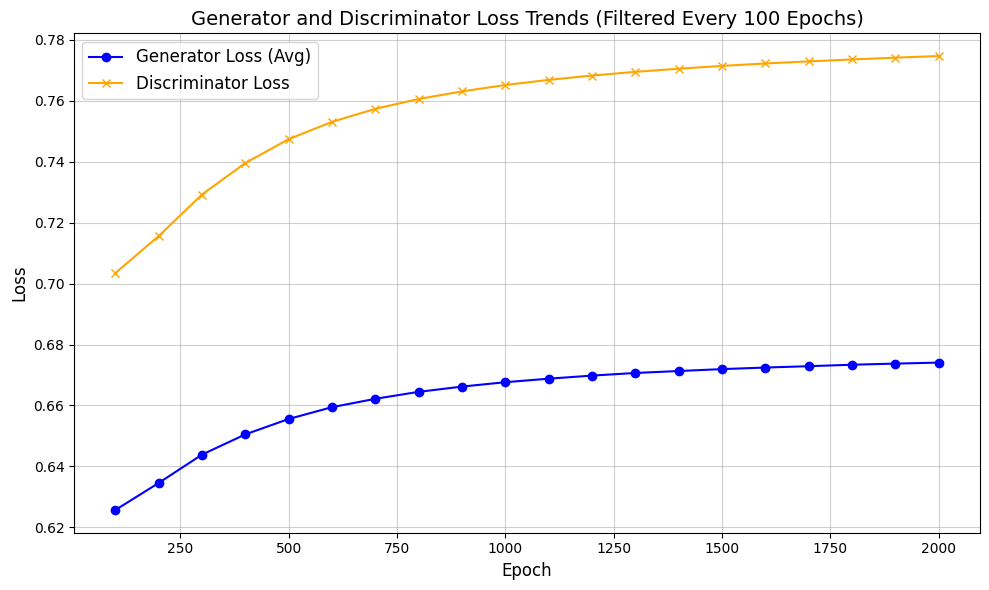

In [ ]:
import matplotlib.pyplot as plt

# Filter the DataFrame to include only every 100th epoch
loss_trends_df_filtered_2 = loss_trends_df_2[loss_trends_df_2['Epoch'] % 100 == 0]

# Plot the average Generator Loss and Discriminator Loss
plt.figure(figsize=(10, 6))

# Plot Generator Loss (Avg)
plt.plot(loss_trends_df_filtered_2['Epoch'], loss_trends_df_filtered_2['Generator Loss (Avg)'],
         label='Generator Loss (Avg)', color='blue', marker='o')

# Plot Discriminator Loss
plt.plot(loss_trends_df_filtered_2['Epoch'], loss_trends_df_filtered_2['Discriminator Loss'],
         label='Discriminator Loss', color='orange', marker='x')

# Add titles and labels
plt.title('Generator and Discriminator Loss Trends (Filtered Every 100 Epochs)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()


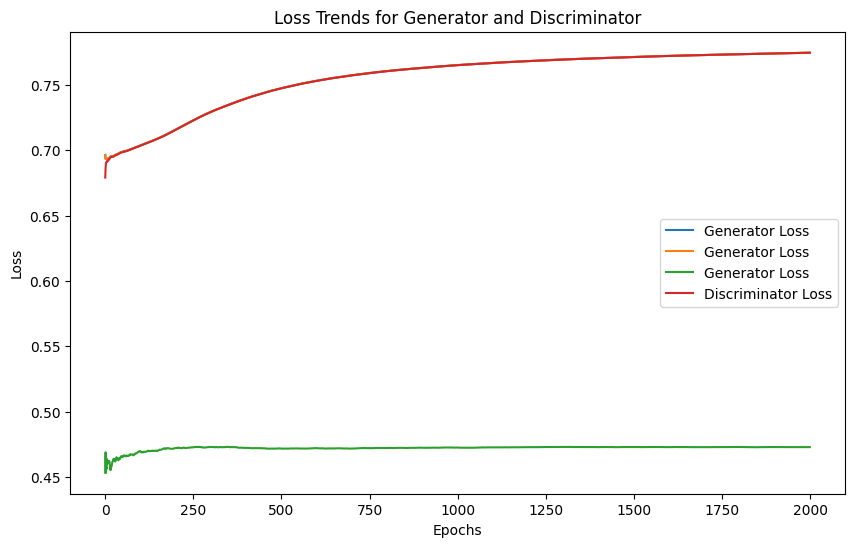

In [ ]:
# Plot loss trends
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(g_loss_history_2, label='Generator Loss')
plt.plot(d_loss_history_2, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Trends for Generator and Discriminator')
plt.legend()
plt.show()

In [ ]:
# # Create a DataFrame for loss trends, selecting every 100th epoch
# loss_trends_df_2 = pd.DataFrame({
#     'Epoch': list(range(1, len(g_loss_history_2) + 1)),  # Add epoch numbers starting from 1
#     'Generator Loss': g_loss_history_2,
#     'Discriminator Loss': d_loss_history_2
# })

# # Filter the DataFrame to include only every 100th epoch
# loss_trends_df_filtered_2 = loss_trends_df_2[loss_trends_df_2['Epoch'] % 100 == 0]

# # Display the filtered loss trends DataFrame
# print("\nLoss Trends Comparison Table (Every 100 Epochs):")
# loss_trends_df_filtered_2


In [ ]:
# Generate 10,000 synthetic samples
noise = np.random.normal(0, 1, (10000, input_dim)).astype(np.float32)
synthetic_data_2 = generator.predict(noise)

synthetic_data_reshaped_2 = synthetic_data_2.reshape(-1, output_dim)
original_scale_data_2 = scaler.inverse_transform(synthetic_data_reshaped_2)  # Rescale synthetic data
synthetic_data_df_2 = pd.DataFrame(original_scale_data_2, columns=training_data.columns)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


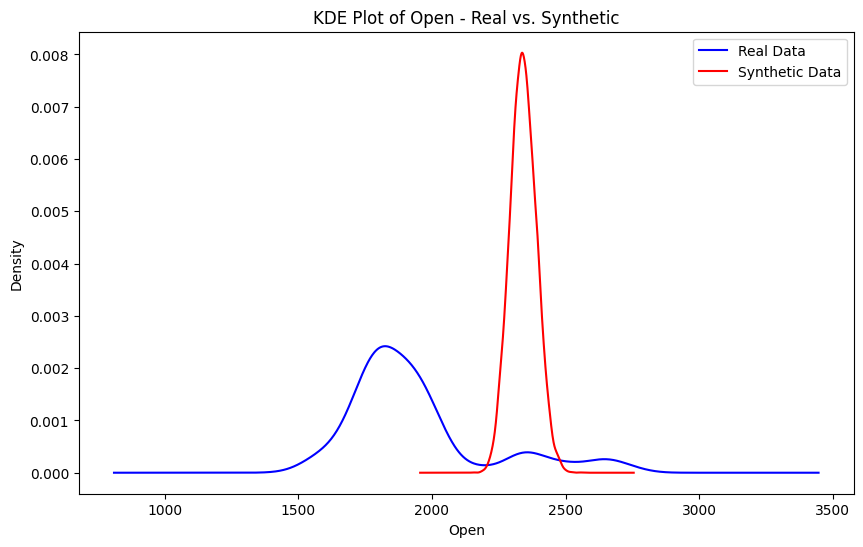

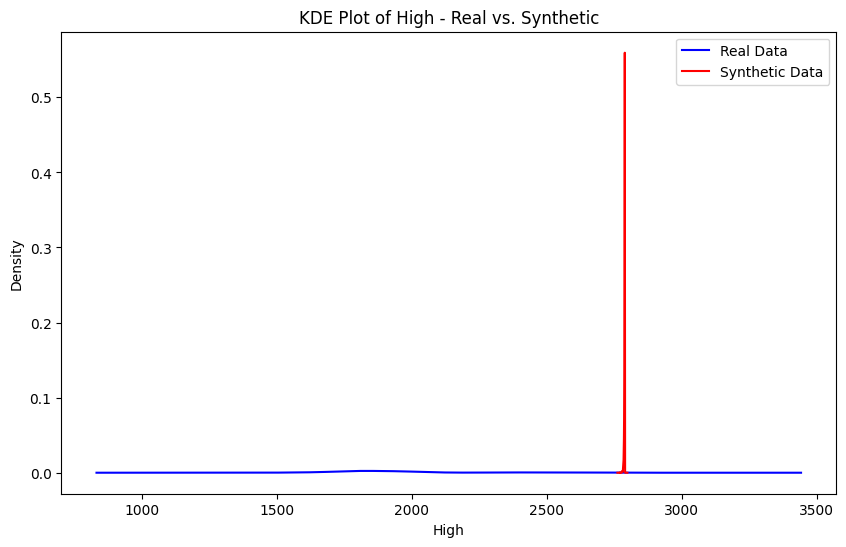

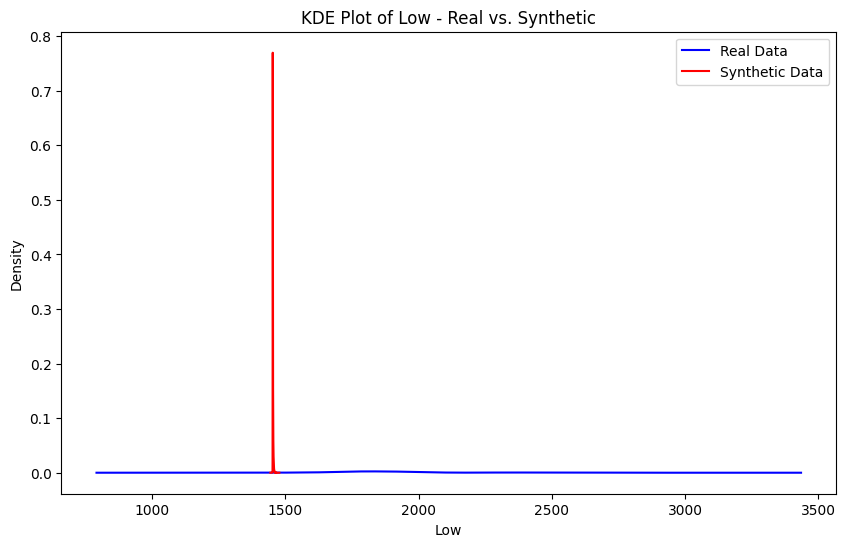

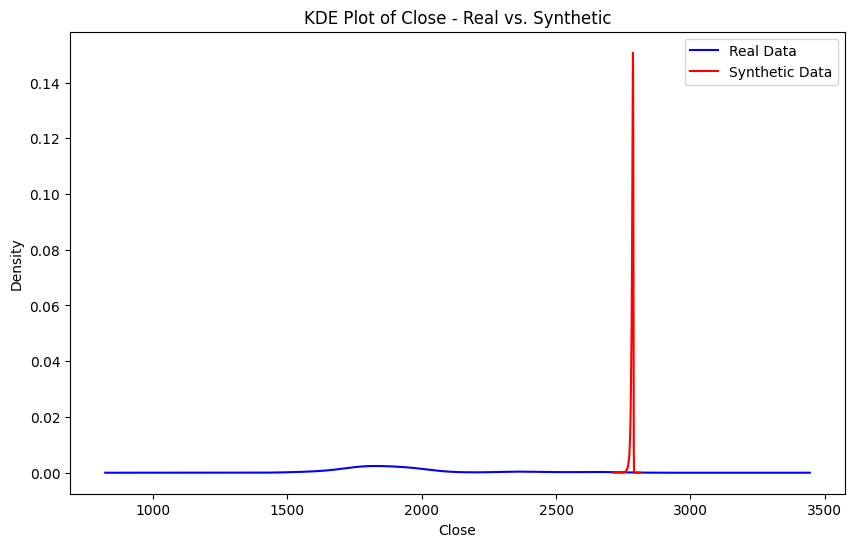

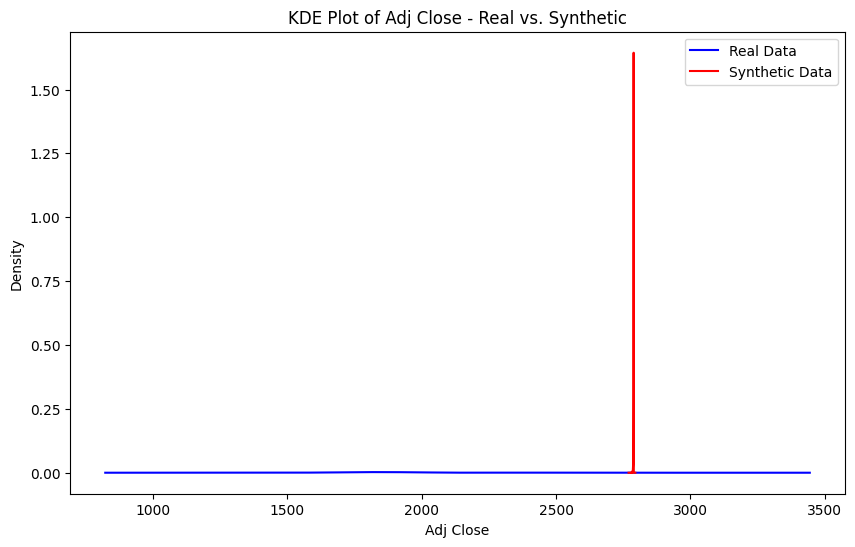

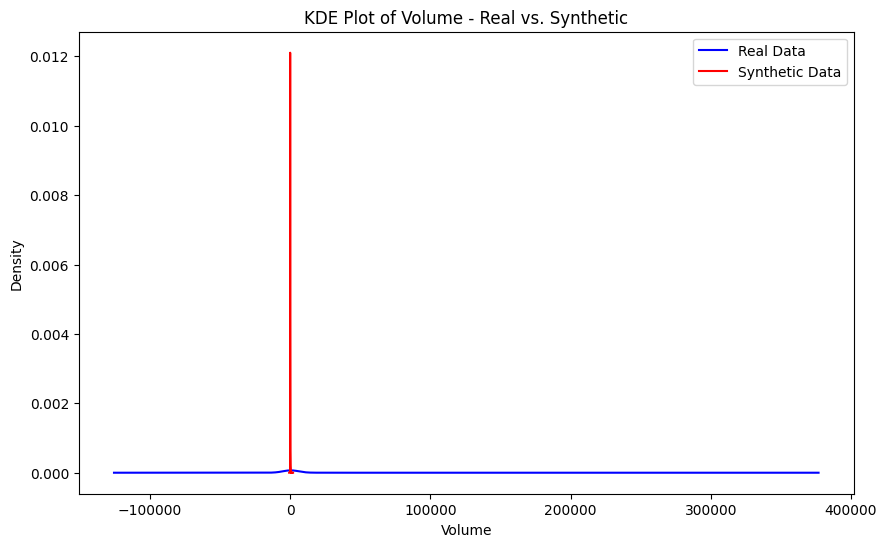

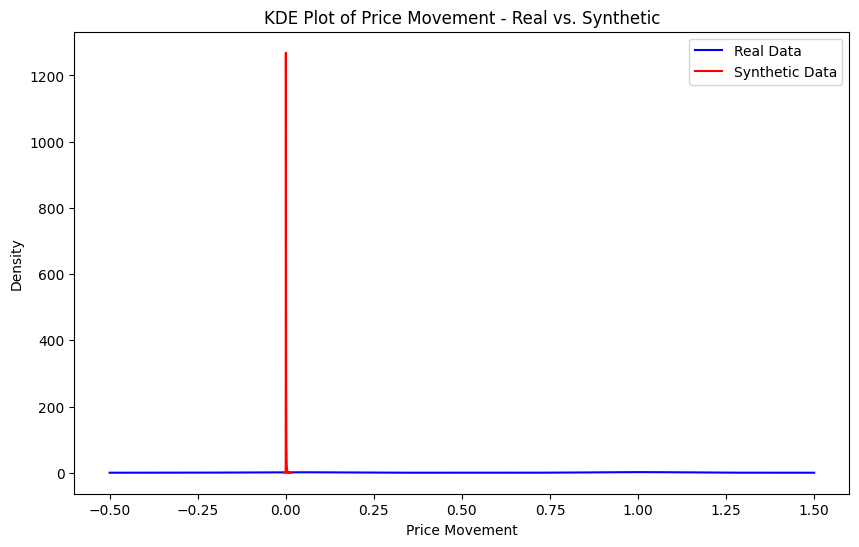

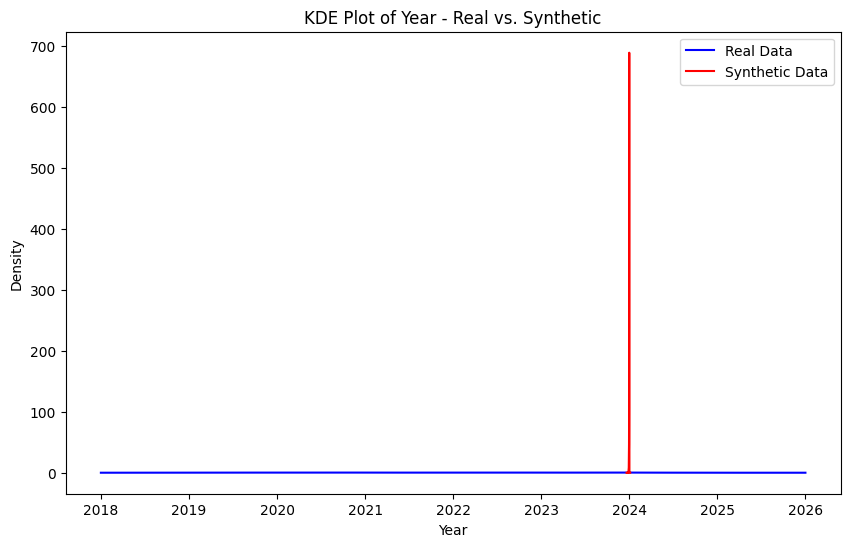

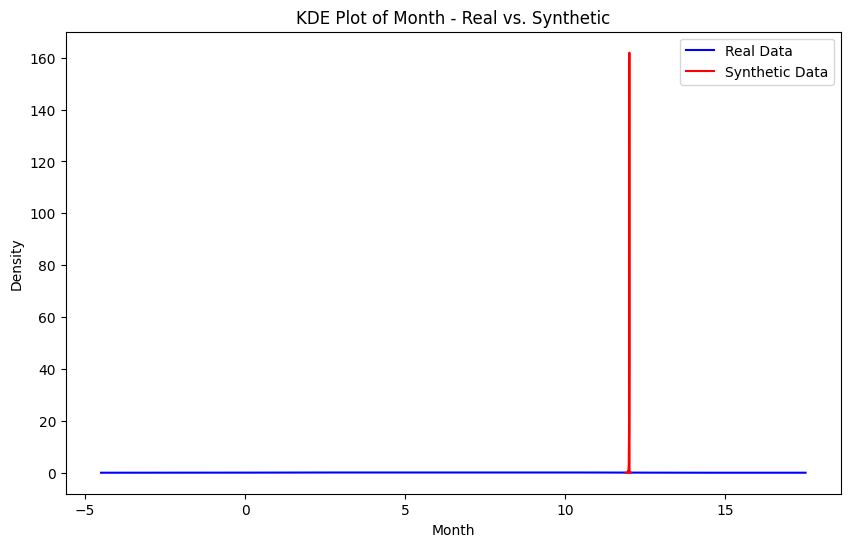

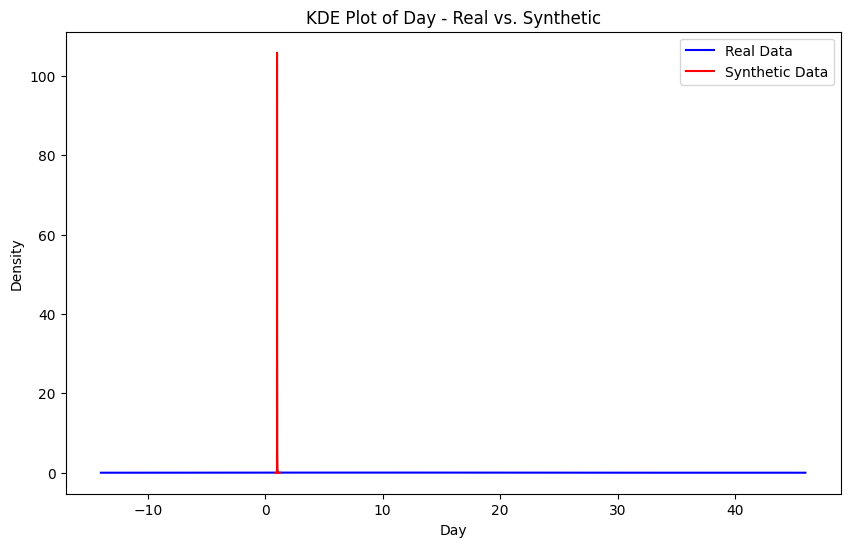

In [ ]:
 #Compare distributions using Kernel Density Estimation (KDE) plots
for col in data.columns:
    plt.figure(figsize=(10, 6))
    data[col].plot.kde(label='Real Data', color='blue')
    synthetic_data_df_2[col].plot.kde(label='Synthetic Data', color='red')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.title(f'KDE Plot of {col} - Real vs. Synthetic')
    plt.legend(loc='upper right')
    plt.show()


In [ ]:
# Statistical comparison
real_stats_2 = data.describe()
synthetic_stats_2 = synthetic_data_df_2.describe()

print("\nReal Data Statistics_2:")
real_stats_2




Real Data Statistics_2:


,Open,High,Low,Close,Adj Close,Volume,Price Movement,Year,Month,Day
count,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000
mean,1935.453574,1945.315985,1925.952770,1935.689395,1935.689395,4225.694779,0.548594,2021.983133,6.503614,15.635341
std,260.426016,261.177932,259.766152,260.533468,260.533468,23181.283059,0.497833,1.410983,3.409278,8.765911
min,1469.300049,1484.000000,1452.099976,1477.300049,1477.300049,0.000000,0.000000,2020.000000,1.000000,1.000000
25%,1779.500000,1787.800049,1770.099976,1777.199951,1777.199951,74.000000,0.000000,2021.000000,4.000000,8.000000
50%,1869.300049,1876.000000,1862.599976,1868.300049,1868.300049,231.000000,1.000000,2022.000000,7.000000,15.000000
75%,1988.199951,1994.599976,1977.699951,1985.000000,1985.000000,645.000000,1.000000,2023.000000,9.000000,23.000000
max,2787.399902,2789.000000,2774.600098,2788.500000,2788.500000,251274.000000,1.000000,2024.000000,12.000000,31.000000


In [ ]:
print("\nSynthetic Data Statistics_2:")
synthetic_stats_2


Synthetic Data Statistics_2:


,Open,High,Low,Close,Adj Close,Volume,Price Movement,Year,Month,Day
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2341.377197,2787.572754,1453.135742,2783.049316,2788.017334,66.148224,0.000627,2023.999023,11.995063,1.007495
std,49.256210,1.413058,1.176669,4.470044,0.655823,85.062691,0.000707,0.001883,0.005739,0.009507
min,2155.548828,2770.461426,1452.105957,2738.347656,2775.841309,0.291767,0.000003,2023.979248,11.924939,1.000023
25%,2307.785095,2787.173096,1452.423920,2781.418152,2787.912354,17.543169,0.000195,2023.998657,11.993835,1.001976
50%,2340.436768,2788.001709,1452.761719,2784.307495,2788.228638,38.757189,0.000405,2023.999390,11.996904,1.004400
75%,2374.476807,2788.469788,1453.388245,2786.058472,2788.379639,80.305521,0.000785,2023.999756,11.998559,1.009157
max,2555.059082,2788.986328,1468.901367,2788.358154,2788.498779,1395.459839,0.011287,2024.000000,11.999973,1.184470


# **Gan-3**

**Experiment-1 (batch_size=32 - input_dim=50 - learning_rate=0.0002)**

In [ ]:
training_data = pd.DataFrame(normalized_data)

# Define the dimensions of the data
input_dim = 50  # Size of the random noise vector (input to the generator)
output_dim = training_data.shape[1]  # Number of features in the real dataset (output of the generator)
learning_rate = 0.0002

# Initialize the models
generator = build_generator(input_dim=input_dim, output_dim=output_dim)  # Generator creates fake data
discriminator = build_discriminator(input_dim=output_dim)  # Discriminator evaluates data
gan = build_gan(generator, discriminator)  # GAN combines the two models

# Compile the discriminator
discriminator.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),  # Adam optimizer for stable training
    loss='binary_crossentropy',                        # Binary crossentropy for classification (real or fake)
    metrics=['accuracy']                               # Track accuracy as an additional metric
)

# Compile the GAN
gan.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),  # Adam optimizer for generator updates
    loss='binary_crossentropy'                         # Binary crossentropy for GAN training
)

# Training parameters
epochs = 2000         # Total number of training iterations
batch_size = 32       # Number of samples per batch
half_batch = batch_size // 2  # Half of the batch size for discriminator training

# Ensure training data is in the correct format
normlized_data = training_data.astype(np.float32)  # Convert to 32-bit float (required by TensorFlow)

# Track loss trends
g_loss_history_3 = []
d_loss_history_3 = []

# Start training the GAN
for epoch in range(epochs):
    # Train the discriminator
    # Select a random batch of real data
    idx = np.random.randint(0, training_data.shape[0], half_batch)
    real_data = training_data.iloc[idx].values  # Use .iloc and convert to NumPy array

    # Generate fake data using the generator
    noise = np.random.normal(0, 1, (half_batch, input_dim)).astype(np.float32)  # Random noise as input
    fake_data = generator.predict(noise).astype(np.float32)  # Fake data output

    # Define labels for real (1) and fake (0) data
    real_labels = np.ones((half_batch, 1), dtype=np.float32)
    fake_labels = np.zeros((half_batch, 1), dtype=np.float32)

    # Train the discriminator on real data and fake data
    d_loss_real = discriminator.train_on_batch(real_data, real_labels)  # Train on real data
    d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)  # Train on fake data

    # Calculate the average loss of the discriminator
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator via the GAN
    noise = np.random.normal(0, 1, (batch_size, input_dim)).astype(np.float32)
    valid_labels = np.ones((batch_size, 1), dtype=np.float32)  # Labels for GAN training (all real)

    # Train the generator to "fool" the discriminator
    g_loss = gan.train_on_batch(noise, valid_labels)

    # Track loss
    g_loss_history_3.append(g_loss)
    d_loss_history_3.append(d_loss[0])

    # Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss[0]}, D Accuracy: {d_loss[1]} | G Loss: {g_loss}")






/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0 | D Loss: 0.7204688787460327, D Accuracy: 0.34375 | G Loss: [array(0.7027382, dtype=float32), array(0.7027382, dtype=float32), array(0.5625, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

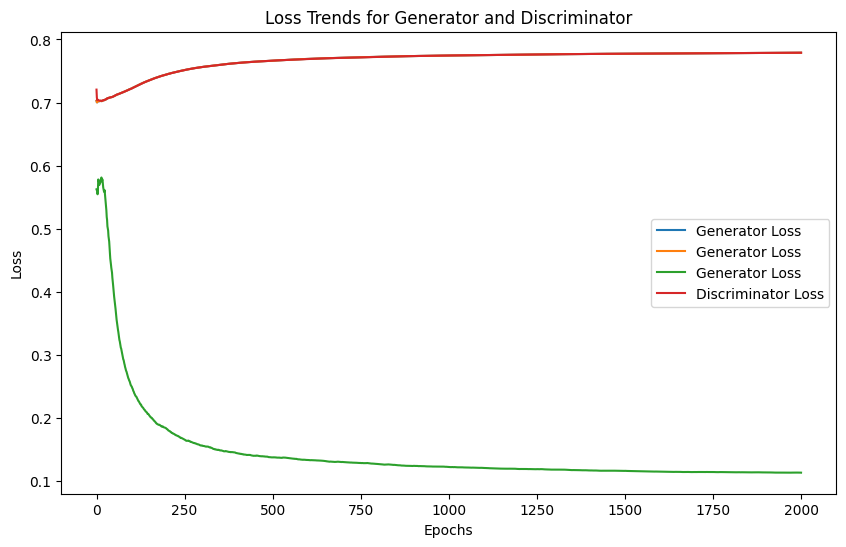

In [ ]:
# Plot loss trends
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(g_loss_history_3, label='Generator Loss')
plt.plot(d_loss_history_3, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Trends for Generator and Discriminator')
plt.legend()
plt.show()

In [ ]:
# Create a DataFrame for loss trends
loss_trends_df_3 = pd.DataFrame({
    'Epoch': list(range(1, len(g_loss_history_3) + 1)),
    'Generator Loss': g_loss_history_3,
    'Discriminator Loss': d_loss_history_3
})

# Compute the average Generator Loss for each epoch
loss_trends_df_3['Generator Loss (Avg)'] = loss_trends_df_3['Generator Loss'].apply(lambda x: sum(x) / len(x) if isinstance(x, list) else x)

# Filter the DataFrame to include only every 100th epoch
loss_trends_df_filtered_3 = loss_trends_df_3[loss_trends_df_3['Epoch'] % 100 == 0]

# Display the filtered loss trends DataFrame
print("\nLoss Trends Comparison Table (Every 100 Epochs):")
print(loss_trends_df_filtered_3[['Epoch', 'Generator Loss (Avg)', 'Discriminator Loss']])



Loss Trends Comparison Table (Every 100 Epochs):
      Epoch  Generator Loss (Avg)  Discriminator Loss
99      100              0.565010            0.722107
199     200              0.557379            0.744485
299     300              0.556440            0.756264
399     400              0.556547            0.762550
499     500              0.556948            0.766420
599     600              0.557358            0.769056
699     700              0.557479            0.770905
799     800              0.557450            0.772444
899     900              0.557220            0.773591
999    1000              0.557275            0.774506
1099   1100              0.557213            0.775224
1199   1200              0.557107            0.775882
1299   1300              0.557150            0.776459
1399   1400              0.557062            0.776955
1499   1500              0.557128            0.777380
1599   1600              0.556937            0.777788
1699   1700              0.55697

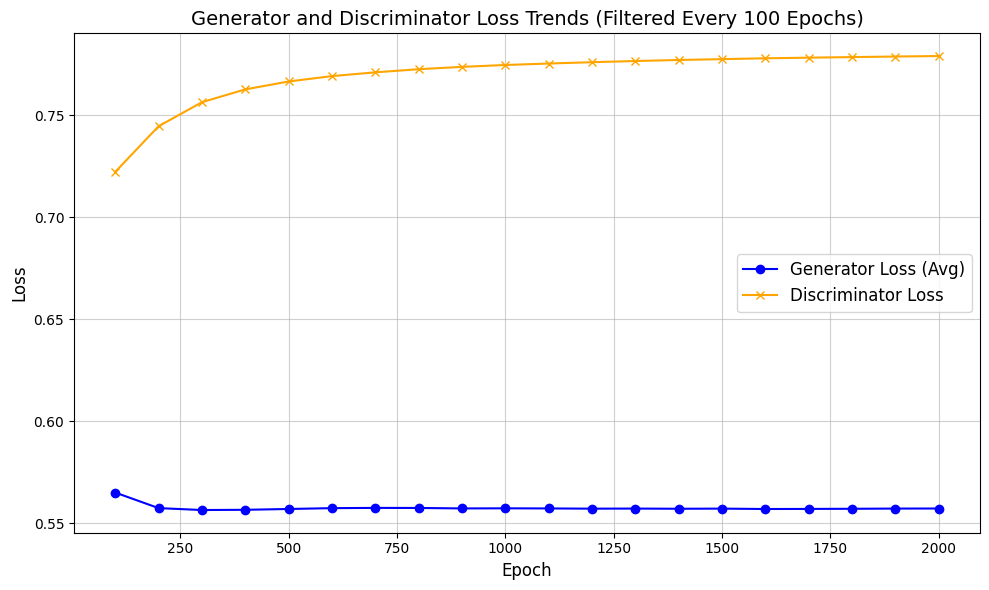

In [ ]:
import matplotlib.pyplot as plt

# Filter the DataFrame to include only every 100th epoch
loss_trends_df_filtered_3 = loss_trends_df_3[loss_trends_df_3['Epoch'] % 100 == 0]

# Plot the average Generator Loss and Discriminator Loss
plt.figure(figsize=(10, 6))

# Plot Generator Loss (Avg)
plt.plot(loss_trends_df_filtered_3['Epoch'], loss_trends_df_filtered_3['Generator Loss (Avg)'],
         label='Generator Loss (Avg)', color='blue', marker='o')

# Plot Discriminator Loss
plt.plot(loss_trends_df_filtered_3['Epoch'], loss_trends_df_filtered_3['Discriminator Loss'],
         label='Discriminator Loss', color='orange', marker='x')

# Add titles and labels
plt.title('Generator and Discriminator Loss Trends (Filtered Every 100 Epochs)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Generate 10,000 synthetic samples
noise = np.random.normal(0, 1, (10000, input_dim)).astype(np.float32)
synthetic_data_3 = generator.predict(noise)

synthetic_data_reshaped_3 = synthetic_data_3.reshape(-1, output_dim)
original_scale_data_3 = scaler.inverse_transform(synthetic_data_reshaped_3)  # Rescale synthetic data
synthetic_data_df_3 = pd.DataFrame(original_scale_data_3, columns=training_data.columns)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


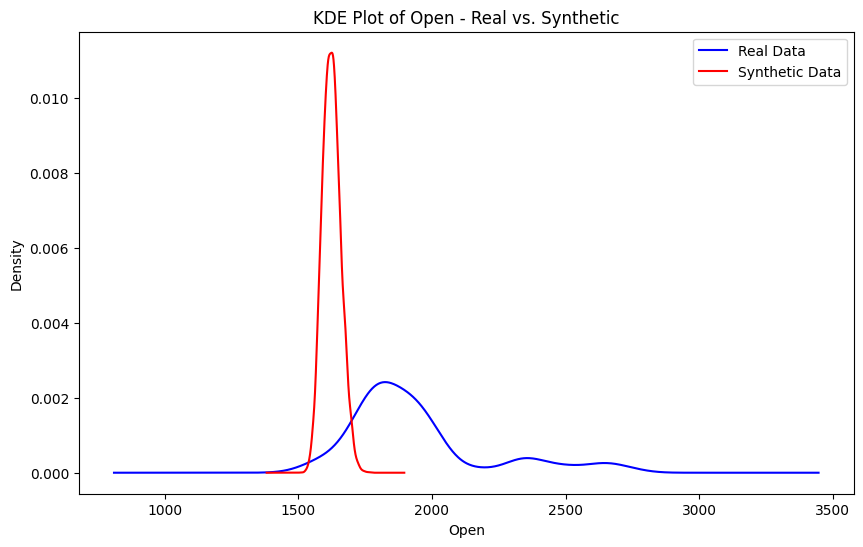

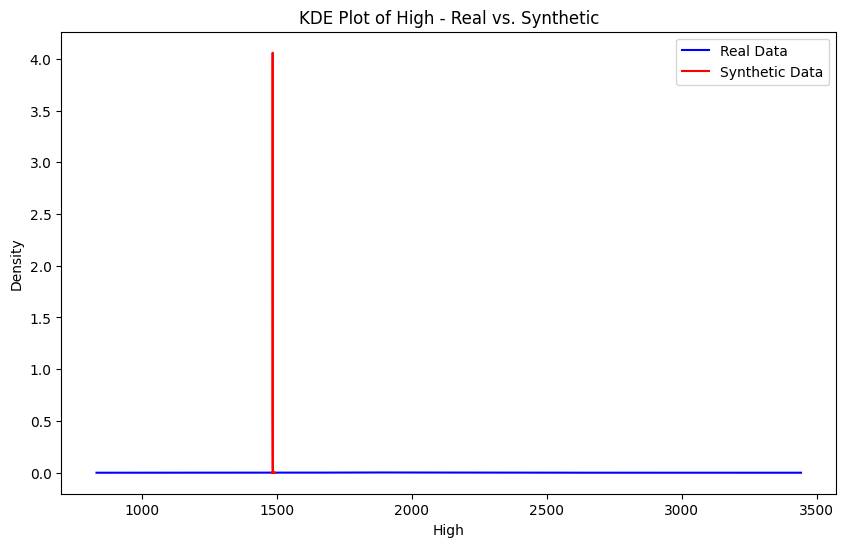

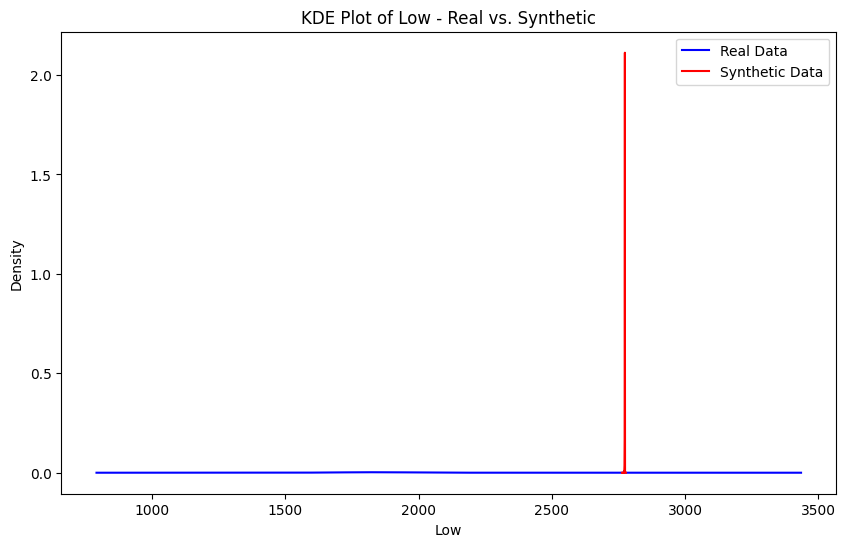

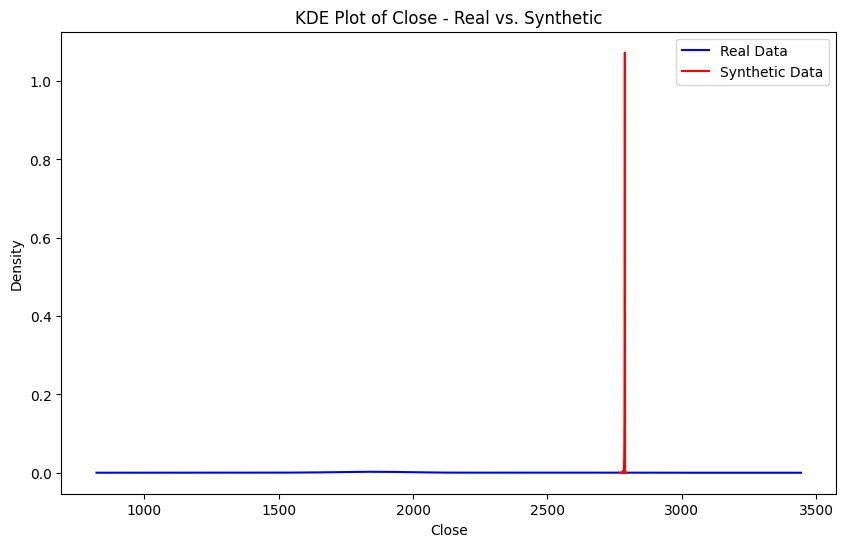

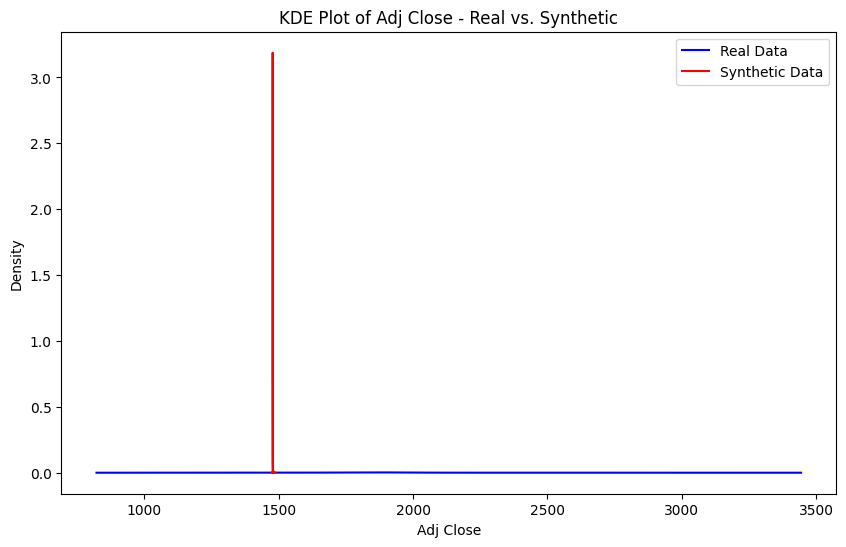

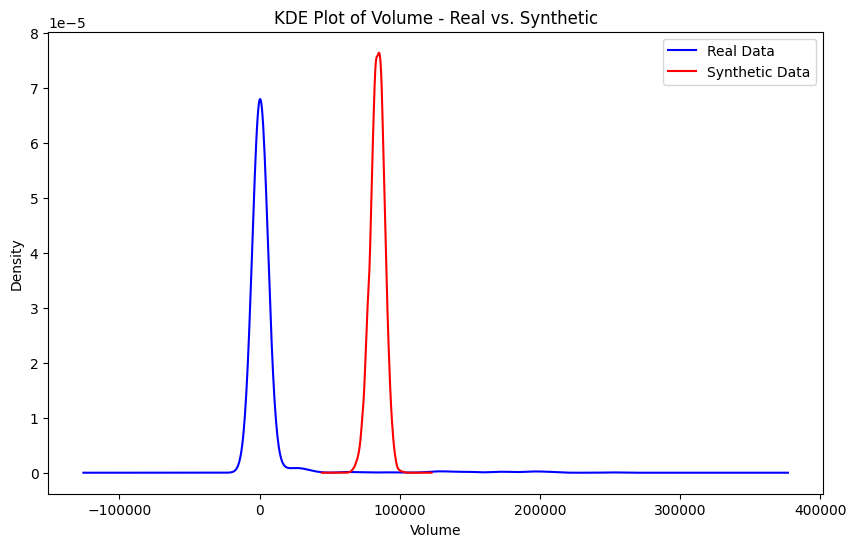

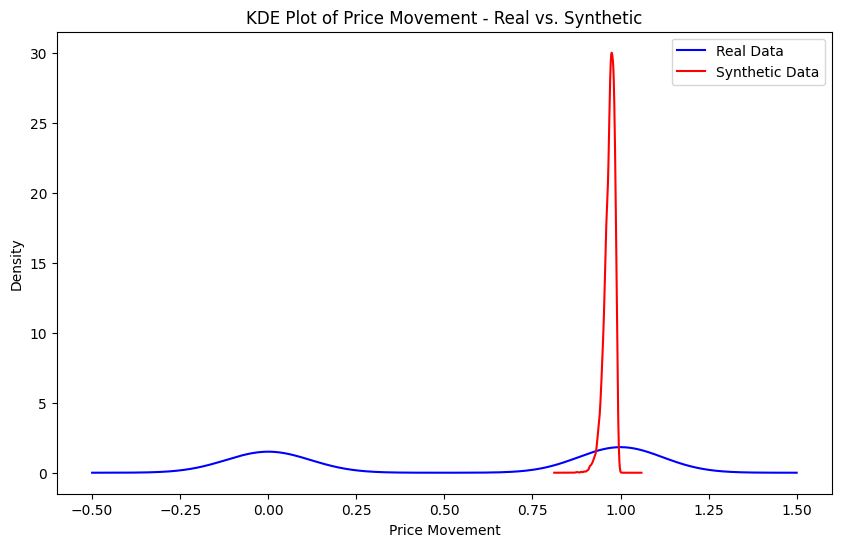

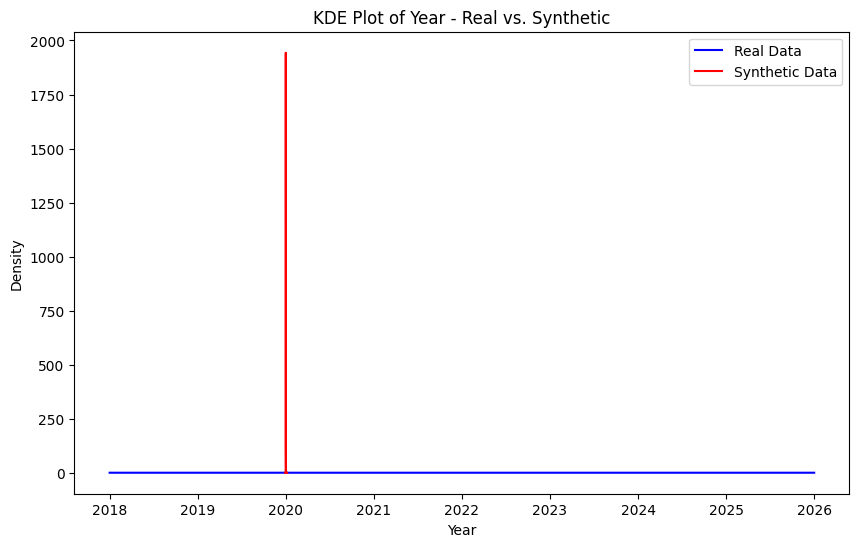

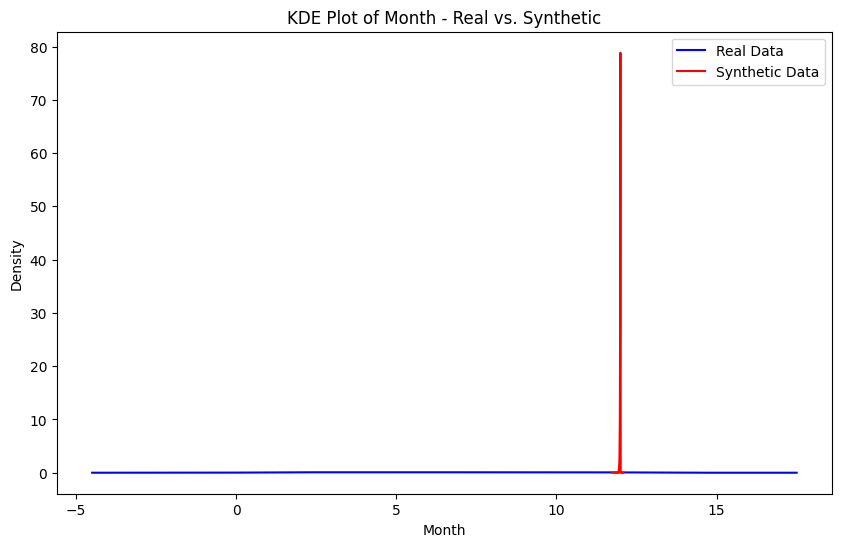

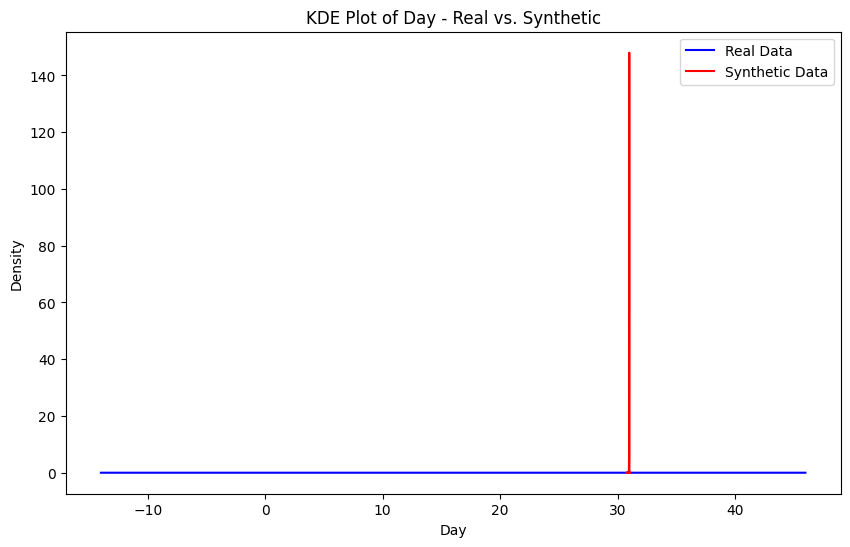

In [ ]:
 #Compare distributions using Kernel Density Estimation (KDE) plots
for col in data.columns:
    plt.figure(figsize=(10, 6))
    data[col].plot.kde(label='Real Data', color='blue')
    synthetic_data_df_3[col].plot.kde(label='Synthetic Data', color='red')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.title(f'KDE Plot of {col} - Real vs. Synthetic')
    plt.legend(loc='upper right')
    plt.show()


In [ ]:
# Statistical comparison
real_stats_3 = data.describe()
synthetic_stats_3 = synthetic_data_df_3.describe()

print("\nReal Data Statistics_2:")
real_stats_3




Real Data Statistics_2:


,Open,High,Low,Close,Adj Close,Volume,Price Movement,Year,Month,Day
count,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000
mean,1935.453574,1945.315985,1925.952770,1935.689395,1935.689395,4225.694779,0.548594,2021.983133,6.503614,15.635341
std,260.426016,261.177932,259.766152,260.533468,260.533468,23181.283059,0.497833,1.410983,3.409278,8.765911
min,1469.300049,1484.000000,1452.099976,1477.300049,1477.300049,0.000000,0.000000,2020.000000,1.000000,1.000000
25%,1779.500000,1787.800049,1770.099976,1777.199951,1777.199951,74.000000,0.000000,2021.000000,4.000000,8.000000
50%,1869.300049,1876.000000,1862.599976,1868.300049,1868.300049,231.000000,1.000000,2022.000000,7.000000,15.000000
75%,1988.199951,1994.599976,1977.699951,1985.000000,1985.000000,645.000000,1.000000,2023.000000,9.000000,23.000000
max,2787.399902,2789.000000,2774.600098,2788.500000,2788.500000,251274.000000,1.000000,2024.000000,12.000000,31.000000


In [ ]:
print("\nSynthetic Data Statistics_2:")
synthetic_stats_3


Synthetic Data Statistics_2:


,Open,High,Low,Close,Adj Close,Volume,Price Movement,Year,Month,Day
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1624.379639,1484.195557,2774.225098,2787.761963,1477.549683,84057.890625,0.968873,2020.000244,11.989920,30.994669
std,34.065346,0.263994,0.455555,0.808683,0.306885,5155.340820,0.014821,0.000638,0.010118,0.006880
min,1510.175903,1484.001099,2767.269043,2775.870117,1477.301514,64038.937500,0.873649,2020.000000,11.819829,30.833313
25%,1600.141296,1484.051147,2774.124451,2787.546631,1477.372070,80759.201172,0.960524,2020.000122,11.987028,30.993364
50%,1622.907959,1484.112427,2774.363403,2788.015747,1477.453613,84238.867188,0.971436,2020.000244,11.992974,30.996780
75%,1646.777710,1484.239502,2774.489258,2788.264893,1477.610321,87561.697266,0.979756,2020.000488,11.996428,30.998533
max,1767.643188,1489.556274,2774.597168,2788.496582,1484.212158,103167.648438,0.997482,2020.010254,11.999868,30.999968


# **Gan-4**

**Experiment-1 (batch_size=64 - input_dim=100 - learning_rate=0.0001)**

In [ ]:
training_data = pd.DataFrame(normalized_data)

# Define the dimensions of the data
input_dim = 100  # Size of the random noise vector (input to the generator)
output_dim = training_data.shape[1]  # Number of features in the real dataset (output of the generator)
learning_rate = 0.0001

# Initialize the models
generator = build_generator(input_dim=input_dim, output_dim=output_dim)  # Generator creates fake data
discriminator = build_discriminator(input_dim=output_dim)  # Discriminator evaluates data
gan = build_gan(generator, discriminator)  # GAN combines the two models

# Compile the discriminator
discriminator.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),  # Adam optimizer for stable training
    loss='binary_crossentropy',                        # Binary crossentropy for classification (real or fake)
    metrics=['accuracy']                               # Track accuracy as an additional metric
)

# Compile the GAN
gan.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),  # Adam optimizer for generator updates
    loss='binary_crossentropy'                         # Binary crossentropy for GAN training
)

# Training parameters
epochs = 2000         # Total number of training iterations
batch_size = 64       # Number of samples per batch
half_batch = batch_size // 2  # Half of the batch size for discriminator training

# Ensure training data is in the correct format
normlized_data = training_data.astype(np.float32)  # Convert to 32-bit float (required by TensorFlow)

# Track loss trends
g_loss_history_4 = []
d_loss_history_4 = []

# Start training the GAN
for epoch in range(epochs):
    # Train the discriminator
    # Select a random batch of real data
    idx = np.random.randint(0, training_data.shape[0], half_batch)
    real_data = training_data.iloc[idx].values  # Use .iloc and convert to NumPy array

    # Generate fake data using the generator
    noise = np.random.normal(0, 1, (half_batch, input_dim)).astype(np.float32)  # Random noise as input
    fake_data = generator.predict(noise).astype(np.float32)  # Fake data output

    # Define labels for real (1) and fake (0) data
    real_labels = np.ones((half_batch, 1), dtype=np.float32)
    fake_labels = np.zeros((half_batch, 1), dtype=np.float32)

    # Train the discriminator on real data and fake data
    d_loss_real = discriminator.train_on_batch(real_data, real_labels)  # Train on real data
    d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)  # Train on fake data

    # Calculate the average loss of the discriminator
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator via the GAN
    noise = np.random.normal(0, 1, (batch_size, input_dim)).astype(np.float32)
    valid_labels = np.ones((batch_size, 1), dtype=np.float32)  # Labels for GAN training (all real)

    # Train the generator to "fool" the discriminator
    g_loss = gan.train_on_batch(noise, valid_labels)

    # Track loss
    g_loss_history_4.append(g_loss)
    d_loss_history_4.append(d_loss[0])

    # Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss[0]}, D Accuracy: {d_loss[1]} | G Loss: {g_loss}")






/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0 | D Loss: 0.7316938638687134, D Accuracy: 0.25 | G Loss: [array(0.68090063, dtype=float32), array(0.68090063, dtype=float32), array(0.5, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

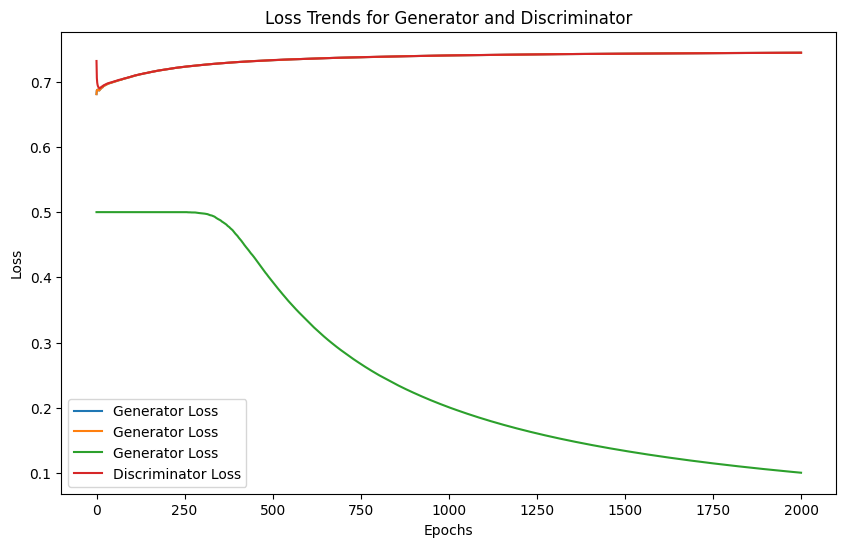

In [13]:
# Plot loss trends
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(g_loss_history_4, label='Generator Loss')
plt.plot(d_loss_history_4, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Trends for Generator and Discriminator')
plt.legend()
plt.show()

In [15]:
# Create a DataFrame for loss trends
loss_trends_df_4 = pd.DataFrame({
    'Epoch': list(range(1, len(g_loss_history_4) + 1)),
    'Generator Loss': g_loss_history_4,
    'Discriminator Loss': d_loss_history_4
})

# Compute the average Generator Loss for each epoch
loss_trends_df_4['Generator Loss (Avg)'] = loss_trends_df_4['Generator Loss'].apply(lambda x: sum(x) / len(x) if isinstance(x, list) else x)

# Filter the DataFrame to include only every 100th epoch
loss_trends_df_filtered_4 = loss_trends_df_4[loss_trends_df_4['Epoch'] % 100 == 0]

# Display the filtered loss trends DataFrame
print("\nLoss Trends Comparison Table (Every 100 Epochs):")
print(loss_trends_df_filtered_4[['Epoch', 'Generator Loss (Avg)', 'Discriminator Loss']])



Loss Trends Comparison Table (Every 100 Epochs):
      Epoch  Generator Loss (Avg)  Discriminator Loss
99      100              0.638503            0.707897
199     200              0.645958            0.718989
299     300              0.649759            0.725608
399     400              0.641367            0.730023
499     500              0.619850            0.733045
599     600              0.600956            0.735069
699     700              0.586608            0.736778
799     800              0.575706            0.738132
899     900              0.567238            0.739227
999    1000              0.560466            0.740201
1099   1100              0.554846            0.740879
1199   1200              0.550218            0.741553
1299   1300              0.546295            0.742113
1399   1400              0.542894            0.742530
1499   1500              0.539982            0.742949
1599   1600              0.537422            0.743297
1699   1700              0.53515

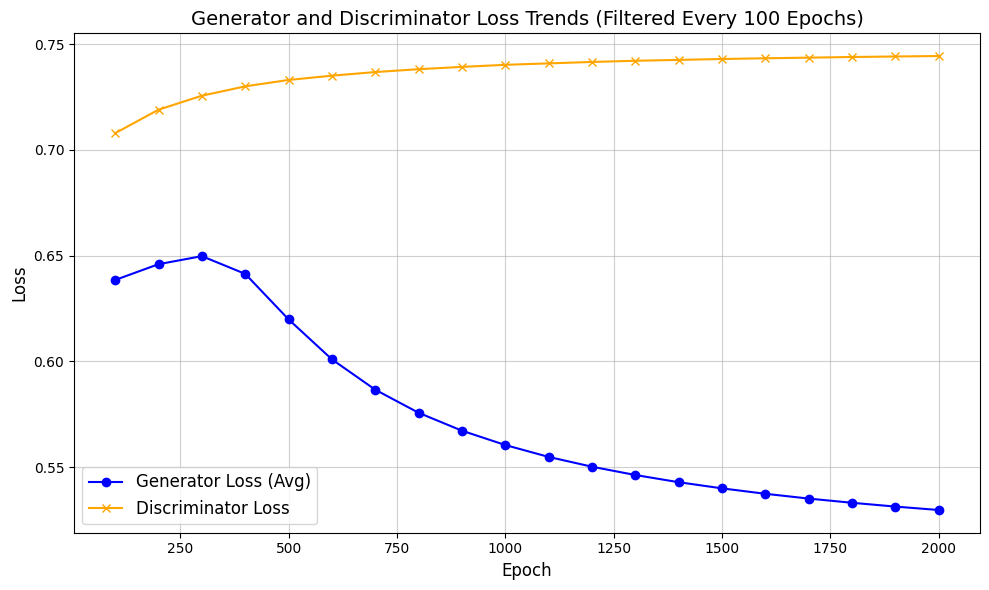

In [16]:
import matplotlib.pyplot as plt

# Filter the DataFrame to include only every 100th epoch
loss_trends_df_filtered_4 = loss_trends_df_4[loss_trends_df_4['Epoch'] % 100 == 0]

# Plot the average Generator Loss and Discriminator Loss
plt.figure(figsize=(10, 6))

# Plot Generator Loss (Avg)
plt.plot(loss_trends_df_filtered_4['Epoch'], loss_trends_df_filtered_4['Generator Loss (Avg)'],
         label='Generator Loss (Avg)', color='blue', marker='o')

# Plot Discriminator Loss
plt.plot(loss_trends_df_filtered_4['Epoch'], loss_trends_df_filtered_4['Discriminator Loss'],
         label='Discriminator Loss', color='orange', marker='x')

# Add titles and labels
plt.title('Generator and Discriminator Loss Trends (Filtered Every 100 Epochs)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()


In [17]:
# Generate 10,000 synthetic samples
noise = np.random.normal(0, 1, (10000, input_dim)).astype(np.float32)
synthetic_data_4 = generator.predict(noise)

synthetic_data_reshaped_4 = synthetic_data_4.reshape(-1, output_dim)
original_scale_data_4 = scaler.inverse_transform(synthetic_data_reshaped_4)  # Rescale synthetic data
synthetic_data_df_4 = pd.DataFrame(original_scale_data_4, columns=training_data.columns)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


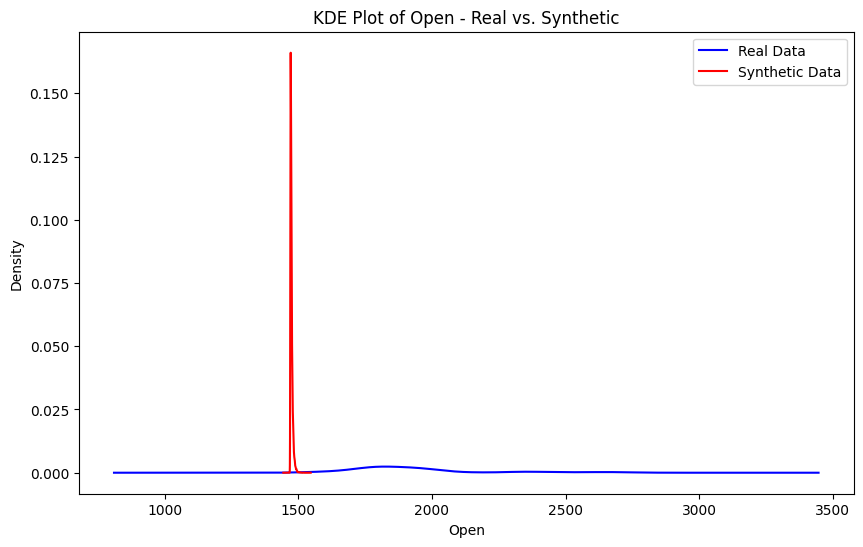

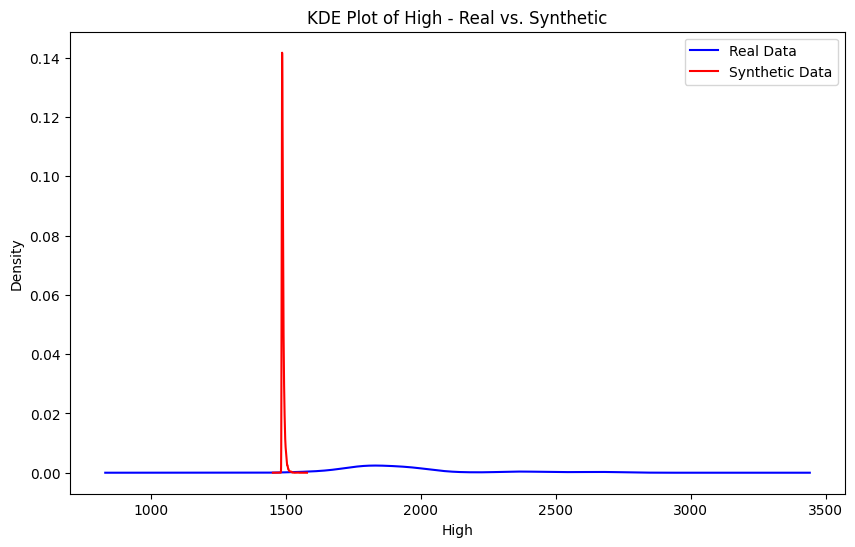

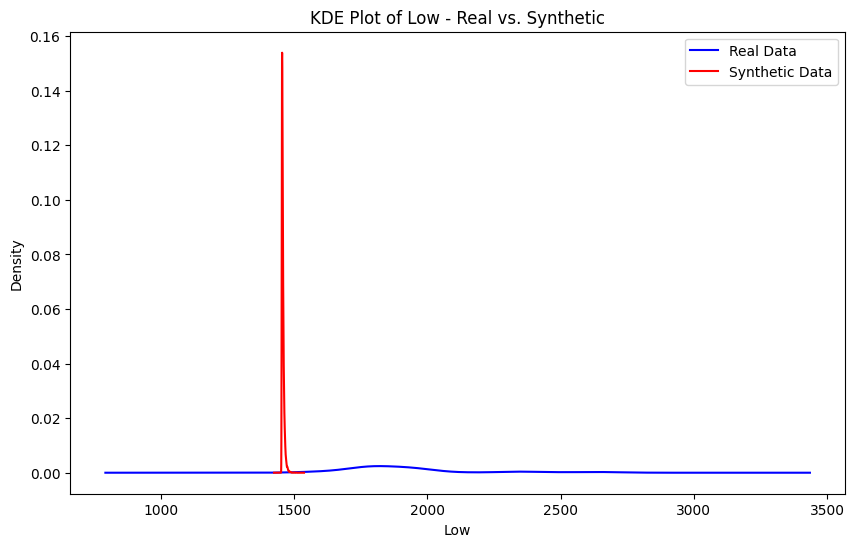

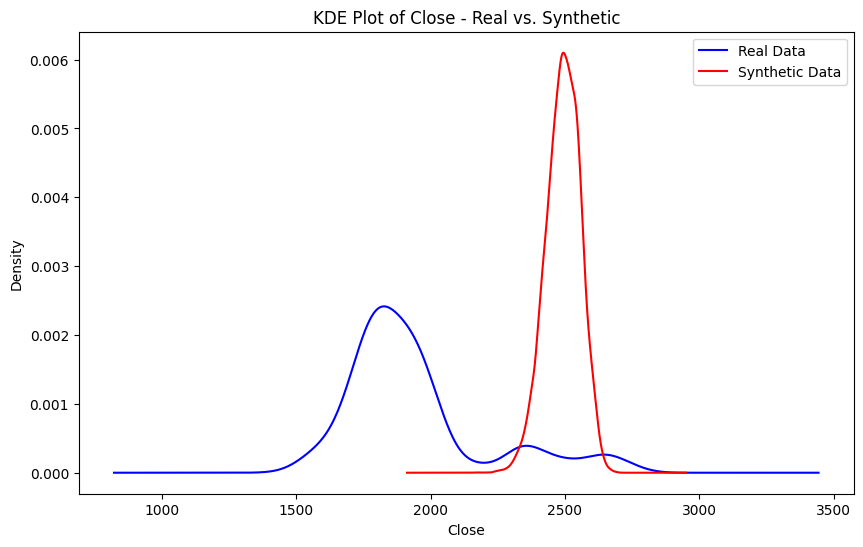

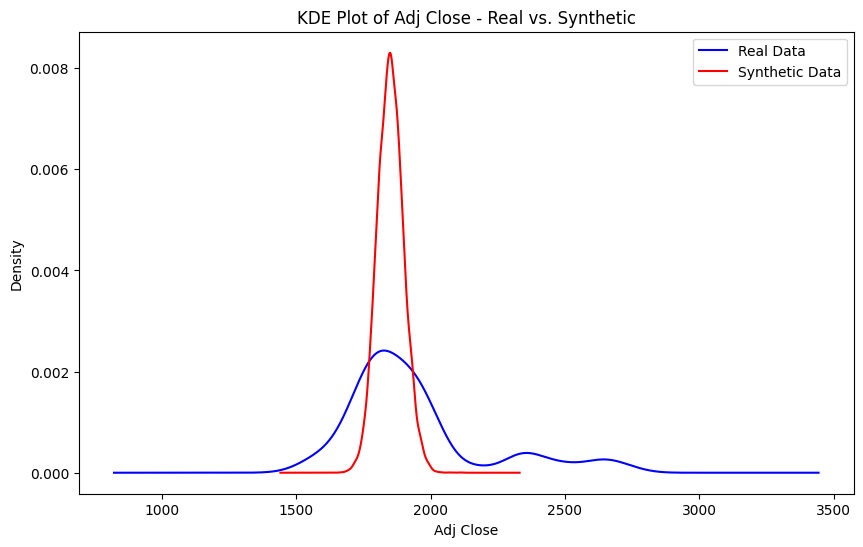

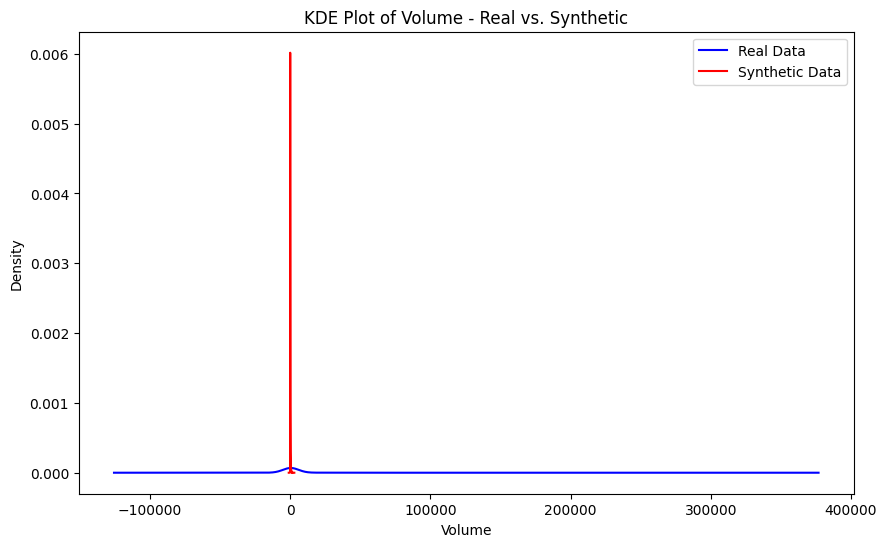

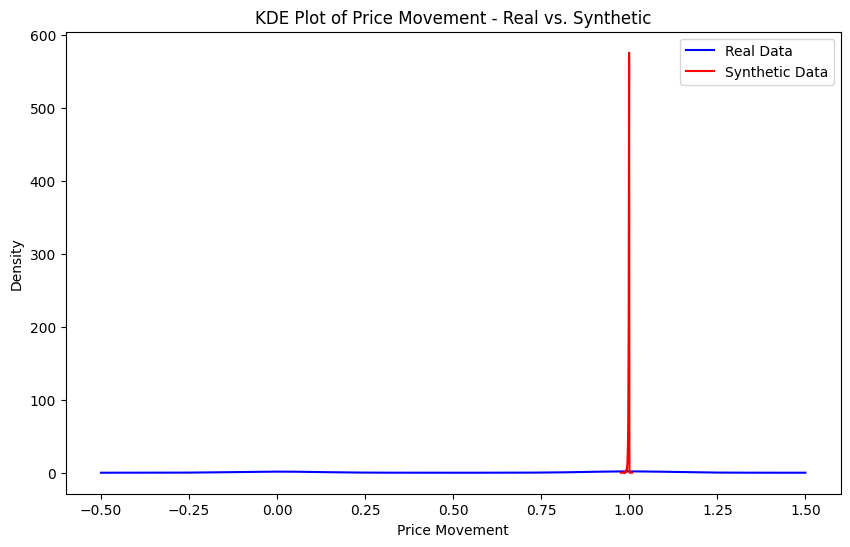

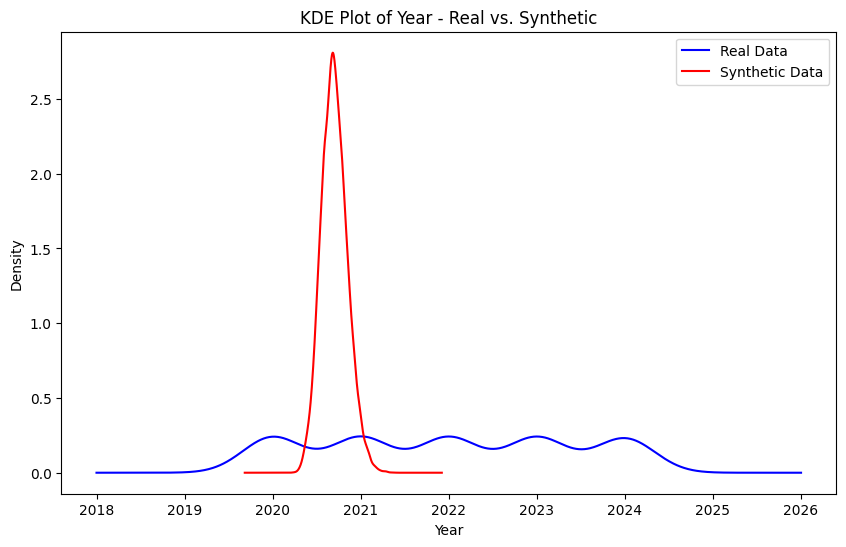

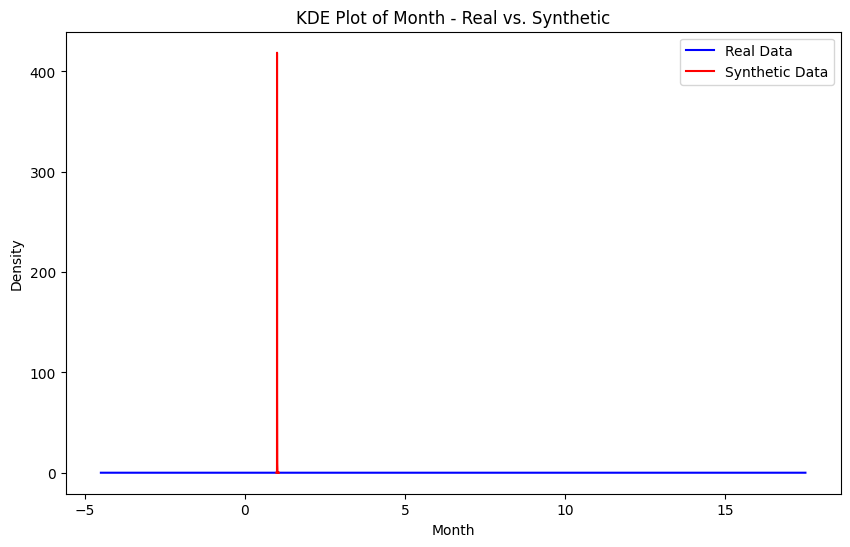

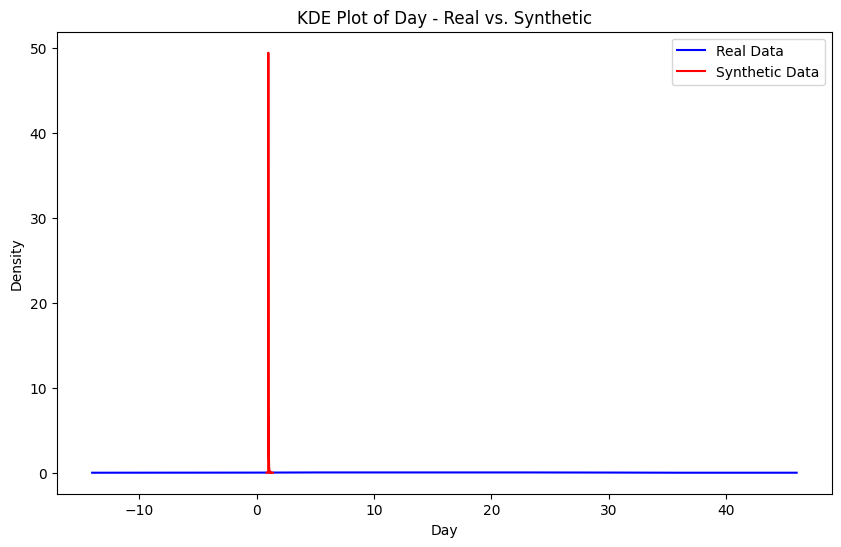

In [18]:
 #Compare distributions using Kernel Density Estimation (KDE) plots
for col in data.columns:
    plt.figure(figsize=(10, 6))
    data[col].plot.kde(label='Real Data', color='blue')
    synthetic_data_df_4[col].plot.kde(label='Synthetic Data', color='red')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.title(f'KDE Plot of {col} - Real vs. Synthetic')
    plt.legend(loc='upper right')
    plt.show()


In [19]:
# Statistical comparison
real_stats_4 = data.describe()
synthetic_stats_4 = synthetic_data_df_4.describe()

print("\nReal Data Statistics_4:")
real_stats_4




Real Data Statistics_4:


,Open,High,Low,Close,Adj Close,Volume,Price Movement,Year,Month,Day
count,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000
mean,1935.453574,1945.315985,1925.952770,1935.689395,1935.689395,4225.694779,0.548594,2021.983133,6.503614,15.635341
std,260.426016,261.177932,259.766152,260.533468,260.533468,23181.283059,0.497833,1.410983,3.409278,8.765911
min,1469.300049,1484.000000,1452.099976,1477.300049,1477.300049,0.000000,0.000000,2020.000000,1.000000,1.000000
25%,1779.500000,1787.800049,1770.099976,1777.199951,1777.199951,74.000000,0.000000,2021.000000,4.000000,8.000000
50%,1869.300049,1876.000000,1862.599976,1868.300049,1868.300049,231.000000,1.000000,2022.000000,7.000000,15.000000
75%,1988.199951,1994.599976,1977.699951,1985.000000,1985.000000,645.000000,1.000000,2023.000000,9.000000,23.000000
max,2787.399902,2789.000000,2774.600098,2788.500000,2788.500000,251274.000000,1.000000,2024.000000,12.000000,31.000000


In [20]:
print("\nSynthetic Data Statistics_4:")
synthetic_stats_4


Synthetic Data Statistics_4:


,Open,High,Low,Close,Adj Close,Volume,Price Movement,Year,Month,Day
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1474.107056,1489.699951,1457.223511,2492.380859,1850.776855,133.350479,0.998593,2020.701050,1.001909,1.016046
std,4.248622,4.893945,4.466479,64.089409,48.863388,144.126068,0.001415,0.149360,0.002575,0.018281
min,1469.390015,1484.107788,1452.214355,2171.792480,1663.689331,1.234085,0.983798,2020.242676,1.000004,1.000149
25%,1471.287598,1486.501740,1454.255280,2450.520874,1817.014191,45.218307,0.998185,2020.597626,1.000491,1.005047
50%,1472.849487,1488.332581,1455.952942,2495.205811,1849.907043,89.385796,0.999038,2020.693604,1.001071,1.010337
75%,1475.538910,1491.270630,1458.745880,2538.382446,1882.683411,167.824570,0.999500,2020.794312,1.002306,1.020222
max,1520.596558,1547.233765,1508.480957,2690.719482,2108.830078,1992.630249,0.999978,2021.361450,1.037817,1.269540
